In [1]:
## Styling notebook  --- REMOVE THIS TO USE DEFAULTS 
## This custom styling may not work well with specific Jupyter Lab themes (e.g. dark)
from IPython.core.display import HTML
HTML(open("./styles/custom.css","r").read())

# CryoNIRSP Level 1 FITS Data:  Coronal spectral line fitting (spectroscopy and polarimetry)

DKIST | NSO | CRYONIRSP | 10 September 2024 
--> Prepared for the first CryoNIRSP Data Release by Tom Schad (tschad@nso.edu) 

**Goals of this notebook:**

*  This notebook is provided to DKIST/CryoNIRSP users by the CryoNIRSP team to illustrate ways to work with the coronal spectral data. 
*  The notebook loads CryoNIRSP SP data from the L1 fits files and performs spectral line fits to extract coronal parameters while also accounting for background scattered light introduced by the combination of the sky and telescope + instrument.  It then creates maps of these quantities.
*  It also does full polarimetric line fits, which also mitigates polarimetric crosstalk, in order to extract the line and continuum linear polarization as the line Zeeman circular polarized signal for longitudinal magnetic field diagnostics.

**About the CryoNIRSP data release:**

* On 21 August 2024, the Level 1 data pipeline for the Cryo-NIRSP reached its first official release within the Data Center software stack (https://docs.dkist.nso.edu/projects/cryo-nirsp/en/latest/) 
* The backlog of Cycle 2 CryoNIRSP data was then bulk processed, of which 85 percent was successful and then made available, in accordance with the DKIST Data Policy via the DKIST Data Center Data Archive (https://dkist.data.nso.edu/).
* This is the first public release of the CryoNIRSP spectrograph and context imager data, and it comprises only off-limb coronagraphic data.  Many technical challenges have been overcome to reach this point; albeit, many additional ones (known and unknown) remain.  

**About the data used in this notebook:**

* A single dataset from Cycle 2 Experiment #119 is used here.  This experiment collected many different types of datasets around the time of the April 2024 total solar eclipse that traversed North America. This data resulted from a Director's Discretionary Time (DDT) proposal and all of its data is publically available without an embargo period.
* The dataset used here has an Dataset ID of BZJOM.  This ID is assigned by the Data Center.  The Observing Program ID assigned at the time of execution on summit is "eid_2_119_opr0oJqs_R001.150682.6087226"
* The data consists of a spectropolarimetric raster scan that is centered on the Fe XIII 1074 nm coronal line.  The scan consisted of 51 scan step positions (i.e. scanning of the image across the slit).  At each step position, a full Stokes measurement was acquired 10 times.  Within the Level 1 calibrated data, each unique Stokes parameter, scan step, and repeated measurement are saved into a single RICE compressed FITS file.  And so, in this case, there are 4 x 51 x 10 = 2040 FITS files.  
* Data may be downloaded from:   https://dkist.data.nso.edu?datasetId=BZJOM
* Other datasets in the experiment are available in the data archive:  https://dkist.data.nso.edu/?proposalId=pid_2_119
* *Supplemental data:* We use solar and telluric atlases as part of the model fitting processes.  These are automatically downloaded from the source repositorites via the code in this notebook. See below for more information.

**Important disclaimers:**

* **The data used in this notebook must be downloaded from the Data Center prior to running it.**
* This notebook is **NOT** meant to serve as a definitive ``black box'' for CryoNIRSP spectral analysis.  The novelty and challenges of coronagraphic spectral data require more concerted efforts on the behalf of users to engage with and improve spectral analysis methods.  Feedback to the CryoNIRSP team is encouraged. 
* The ASDF files included in the data distribution have known flaws and errors for the CryoNIRSP data at this time, in particular relating to metadata.  It is thus recommended to work with FITS files directly, as shown in this notebook.
* Analysis methods subject to change. 

**Useful References:** 

* Fehlmann, A. et al. "The Daniel K. Inouye Solar Telescope (DKIST) Cryogenic Near-Infrared Spectro-Polarimeter (Cryo-NIRSP)" Solar Physics. 298 5 (2023)
* Schad, T.A. et al. "Thomson Scattering above Solar Active Regions and an Ad Hoc Polarization Correction Method for the Emissive Corona" The Astrophysical Journal. 943 59S (2023).
* Schad, T.A. et al. "First Infrared Coronal Spectra from DKIST/Cryo-NIRSP: Comparisons with Global MHD Models" The Astrophysical Journal. 943 59S (2023).
* Schad, T.A. et al. "Coronagraph Observations of Si X 1430 nm Acquired by DKIST/Cryo-NIRSP with Methods for Telluric Absorption Correction." The Astrophysical Journal. 965 1, 40S (2024)
* Schad, T.A. et al. "Mapping the Sun’s coronal magnetic field using the Zeeman effect" Science Advances, in press.

In [2]:
## MOSTLY STANDARD PYTHON PACKAGES IN USE AVAILABLE FROM STANDARD REPOSITORIES
import os
import numpy as np
import glob
import warnings 
from tqdm import tqdm
from tqdm.auto import trange 
from datetime import datetime

from scipy import ndimage,signal
from scipy.optimize import differential_evolution, minimize
import multiprocessing 

from astropy.io import fits 
from astropy.time import Time
import astropy.units as u
from astropy.wcs import WCS  
import sunpy.map
from sunpy.coordinates import sun

import hvpy ## helioviewer api for pulling quick context images from SDO/AIA (JPEG2000 compressed) 
from numba import njit  ## Just in time compiler for faster code snippets -- dependency can be removed it njit decorators below are removed. 

### PLOTTING TOOL 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,PowerNorm
%matplotlib inline   
plt.rcParams["figure.dpi"] = 180 
#### Change to widget backend if desired:  %matplotlib widget
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'gray'
plt.rcParams["image.interpolation"] = 'nearest'

# Dataset definition and metadata examination

## Define input dataset directory

* Here we define the directory that holds a single spectrograph dataset.
* The directory as downloaded from the DKIST data center will be named according to the dataset ID (BZJOM)
* Data may be downloaded from:   https://dkist.data.nso.edu?datasetId=BZJOM 
* To run this notebook yourself, input the dataset directory where your local copy of the data resides. 

In [3]:
dataset_directory = '/data/tschad/pid_2_119/BZJOM/'
print(f"Dataset directory: {dataset_directory}")
print(f"Number of FITS files in directory: {len(glob.glob(dataset_directory + '*fits'))}")

Dataset directory: /data/tschad/pid_2_119/BZJOM/
Number of FITS files in directory: 2040


## Locating the FITS files

* Here we get a list of the L1 FITS files from CryoNIRSP.
* In general, each Stokes state will have a separate FITS file, but here *we only load the intensity spectra headers*.  The headers of the other states are largely the same with the exception of the Stokes state metadata.  
* FITS files are RICE compressed (i..e the data and header must be read from HDU #1)
* The filenames have the instrument name and arm (SP ==> spectrograph), timestamp, wavelength, and Stokes state in it. 

In [4]:
## STOKES I IMAGE FILENAMES 
L1_filenames = glob.glob(dataset_directory + '*_I_*.fits')
L1_filenames.sort()  ## sorting using the time stamps

print(f"There are {len(L1_filenames)} L1 Intensity FITS files within the directory")

print("...here are the first few files")
for f in L1_filenames[:5]: print(os.path.basename(f))
print(' ')
print(f"First filename: {os.path.basename(L1_filenames[0])}")
print(f"Last filename:  {os.path.basename(L1_filenames[-1])}")

There are 510 L1 Intensity FITS files within the directory
...here are the first few files
CRYO-NIRSP_SP_2024_03_23T23_08_23_682_01074700_I_BZJOM_L1.fits
CRYO-NIRSP_SP_2024_03_23T23_08_31_085_01074700_I_BZJOM_L1.fits
CRYO-NIRSP_SP_2024_03_23T23_08_38_488_01074700_I_BZJOM_L1.fits
CRYO-NIRSP_SP_2024_03_23T23_08_45_892_01074700_I_BZJOM_L1.fits
CRYO-NIRSP_SP_2024_03_23T23_08_53_295_01074700_I_BZJOM_L1.fits
 
First filename: CRYO-NIRSP_SP_2024_03_23T23_08_23_682_01074700_I_BZJOM_L1.fits
Last filename:  CRYO-NIRSP_SP_2024_03_24T00_11_58_296_01074700_I_BZJOM_L1.fits


## Load all headers to extract some information about the dataset as a whole 

* The "ASDF" files provided with the Data will automatically provide an object that sorts and organizing the data set.
* However we do not use the ASDF file as there are currently metadata issues in that object.  We use the L1 Fits files directly.  
* Its also good to have a better understanding of how the instrument operates to create spatial/temporal coverage of a target

In [5]:
## in case you have the dkist user tools package installed you can load and look at the data set shape using the asdf file
## Note that there are known metadata errors in this asdf file (including both spectral and spatial axes)
try: 
    print('Trying load of dkist user tools to look at ASDF file data shape') 
    import dkist
    dset = dkist.load_dataset(dataset_directory + 'CRYO-NIRSP_L1_20240323T230827_BZJOM_user_tools.asdf')
    print(f"Dataset data shape: {dset.data.shape}")   ## Prints (4, 51, 10, 1917, 902) for BZJOM
except:
    print('....DKIST user tool loading did not work --> thats okay as we load the FITS files directly below')

Trying load of dkist user tools to look at ASDF file data shape
Dataset data shape: (4, 51, 10, 1917, 902)


In [6]:
## GET ALL HEADERS
hdrs = []
for n in trange(len(L1_filenames)): 
    hdrs.append(fits.getheader(L1_filenames[n],ext=1))

  0%|          | 0/510 [00:00<?, ?it/s]

In [7]:
print(f"Data product information at: {hdrs[0]['HEAD_URL']}")

Data product information at: https://docs.dkist.nso.edu/projects/data-products/en/v4.6.0


In [8]:
## Put all of the headers into a dictorary for easier manipulation
hdr_dict = {}
hdr_dict['datetimes'] = np.array([Time(hdr['DATE-AVG']).to_datetime() for hdr in hdrs])  ## datetimes useful for plotting
for key in hdrs[0].keys():
    if key =='COMMENT' or key == '': continue  ## do not include comments and black header cards
    hdr_dict[key] = np.empty(len(hdrs),dtype = 'O')
    for n in range(len(hdrs)):  hdr_dict[key][n] = hdrs[n][key] 

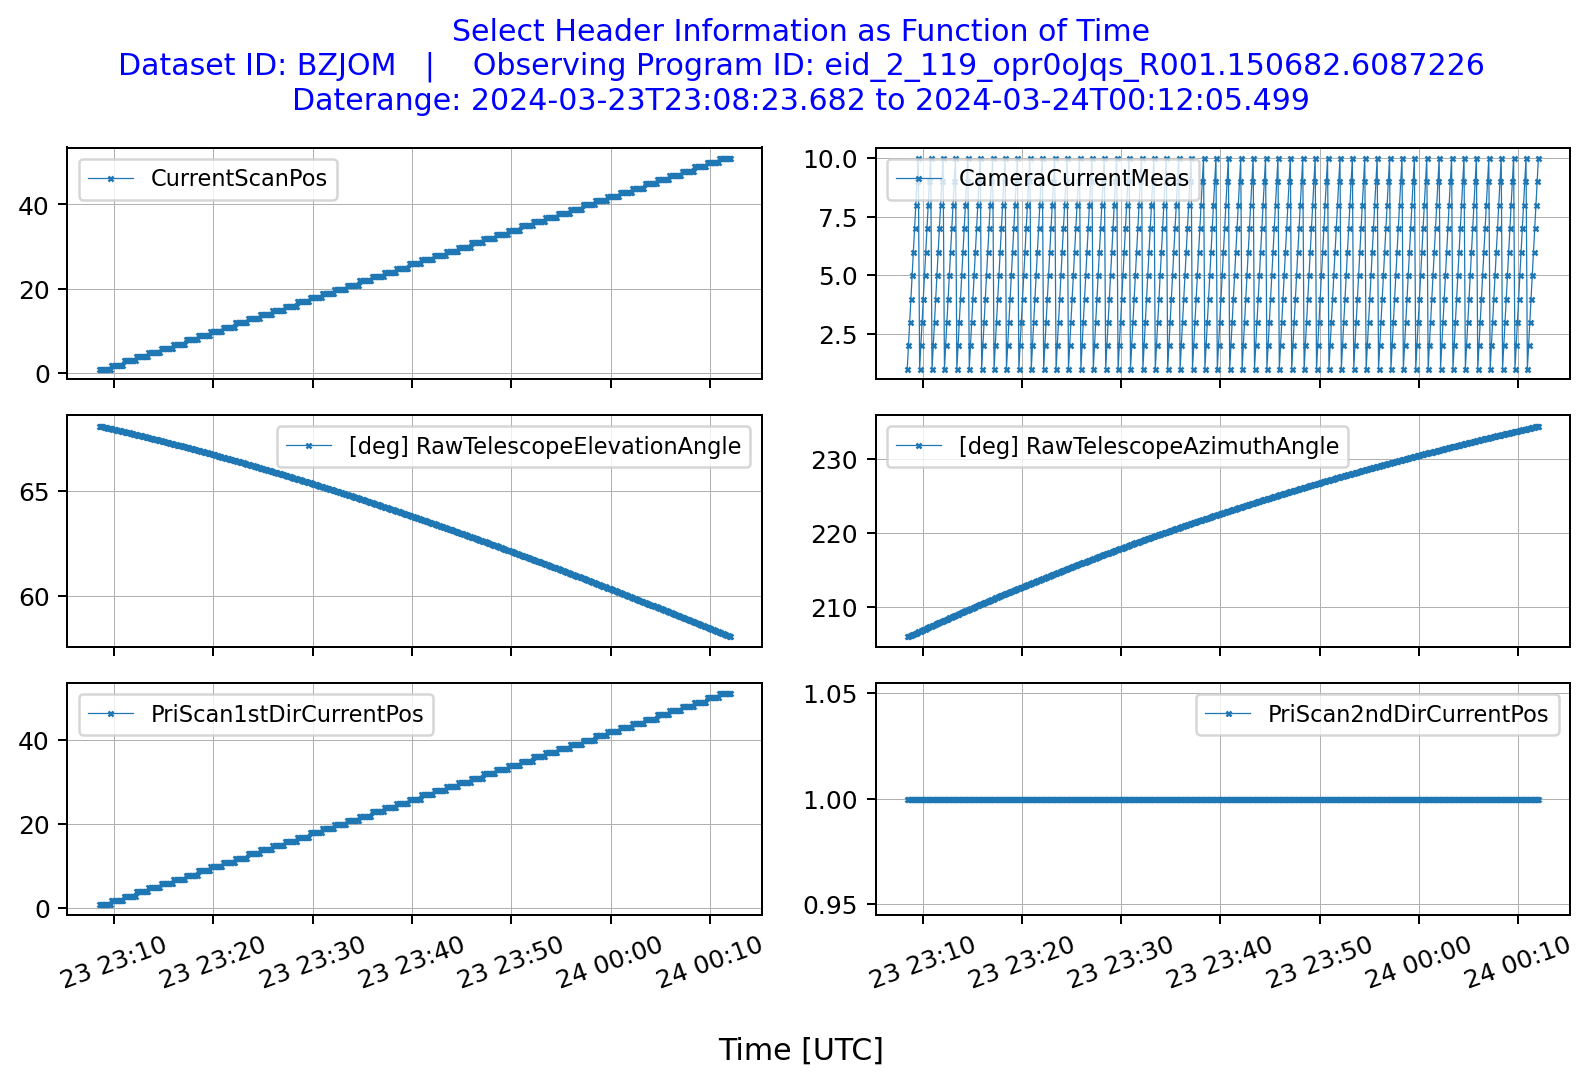

In [9]:
## view a few header keywords as you like to  
## FITS specification with more information is here:  
## https://docs.dkist.nso.edu/projects/data-products/en/stable/specs/spec-214.html

keys2plot = 'CNCURSCN','CNCMEAS','ELEV_ANG','TAZIMUTH','CNP1DCUR','CNP2DCUR',
fig,ax = plt.subplots(len(keys2plot)//2,2,figsize = (9,6),sharex=True)
ax = ax.flatten()
for n,k in enumerate(keys2plot): 
    ax[n].plot(hdr_dict['datetimes'],hdr_dict[k],'x-',lw = 0.5,label = hdrs[0].comments[k],markersize = 2)
for axi in ax: 
    axi.legend(fontsize = 9)
    axi.grid(lw = 0.4)
fig.supxlabel("Time [UTC]")
fig.suptitle('Select Header Information as Function of Time\n' + 
             f"Dataset ID: {hdr_dict['DSETID'][0]}   |    Observing Program ID: {hdr_dict['OBSPR_ID'][0]}\n" +
             f"Daterange: {hdr_dict['DATE-BEG'][0]} to {hdr_dict['DATE-END'][-1]}",fontsize = 12,color = 'blue')
ax[4].tick_params(axis='x', labelrotation=20)
ax[5].tick_params(axis='x', labelrotation=20)
fig.tight_layout()
fig.savefig(f"./figures/select_metadata_vs_time_{hdr_dict['DSETID'][0]}.png",dpi = 300)

## Exposure time information

* At this time, the exposure time that goes into a single Stokes measurement is encoded within multiple metadata entries.  In the future, a cummulative exposure time value may be added.
* The values for this dataset (see below), indicate that individual H2RG detector ramps (i.e. a single exposure to a single modulation state) had a total exposure time of 725 msec.  This ramp consisted of 10 Non-destructive Readouts (NDRs), of which 8 are "Science Frames" (In fast readout, the first two frames correspond to a pixel reset and bias frames).  The individual NDRs have an exposure time of 90.625 msec (90.625 x 8 = 725 msec). 
* The number of modulation states is equal to 8.  So one measured Stokes vector results from 8*725 = 5800 msec of exposure, i.e. 5.8 seconds. 
* At each step position, there are 10 repeats, and so the total integration time at one step position (including all repeats) is 58 seconds.
* The entire map has 51 steps, so 51 * 58 sec ==> 49.3 minutes of total integration time over the dataset (which took ~64 minutes to complete with overheads) 

In [10]:
exposureKeys = ['XPOSURE','TEXPOSUR','CAM_FPS','CNNSCI','CNNNDR','CNMODNST','CNNMEAS']
for key in exposureKeys: 
    print(f"{key.ljust(10)}  {hdrs[0].comments[key].ljust(25)}   {hdrs[0][key]}    ")
print(f"Time between ramps (i.e. triggers): {1./hdrs[0]['CAM_FPS']*1000.} msec")
print(f"Times between first and last trigger: {hdr_dict['datetimes'][-1] -hdr_dict['datetimes'][0]}")

XPOSURE     [ms] FPAExposureTime        725.0    
TEXPOSUR    [ms] CamExposureTime        90.625    
CAM_FPS     [Hz] CamFrameRate           1.0805810232294015    
CNNSCI      CameraNumScienceFrames      8    
CNNNDR      CameraNumNDRs               10    
CNMODNST    ModulatorNumStates          8    
CNNMEAS     CameraNumMeasAtSamePos      10    
Time between ramps (i.e. triggers): 925.42806 msec
Times between first and last trigger: 1:03:34.614500


## Determine data cube size 

In [11]:
## Show information on 1st and 2nd direction scanning (step size and number) 
for k in 'CNP1DSS','CNP1DNSP','CNP2DSS','CNP2DNSP',:
    print(hdrs[0][k+'*'])

if os.path.exists(L1_filenames[0].replace('_I_','_V_')): 
    n_stokes = 4
else: 
    n_stokes = 1

n_scanSteps  = np.max(np.array([hdr['CNCURSCN'] for hdr in hdrs]))
n_measAtStep = np.max(np.array([hdr['CNCMEAS'] for hdr in hdrs]))
n_wv         = hdrs[0]['NAXIS1']
n_alongSlit  = hdrs[0]['NAXIS2']
data_shape   = (n_stokes,n_scanSteps,n_measAtStep,n_alongSlit,n_wv)
print("Data Shape: ",data_shape,' (n_stokes,n_scanSteps,n_measAtStep,n_alongSlit,n_wv)')  ## Note that this matches the asdf data shape above. 

CNP1DSS =                  4.0 / PriScan1stDirStepSize                          END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## Get spectral and spatial coordinates

* As of the first data release, the CryoNIRSP spectral and spatial world coordinates in the Level 1 data include corrections applied at the time of calibration.  Both can still have errors and should be verified manually as necessary and possible.
* The spectral coordinates are determined using an atlas model fit to the flat field spectra acquired at disk center, and does account for Sun-Earth orbital motions.  However, in some cases, the spectra may be shifted in the science data compared to the flat field data, which leads to issues in the metadata.  This occurs in particular when there are spectrograph configuration changes between the flat field and the science data.  
* The spatial coordinates may have inaccuracies of up to ~15 to 20 arcseconds, and there is some non-uniformity in the step width of the image scanning mirror.  These can be as large as an arcsecond. 

In [12]:
########### GET SPECTRAL DISPERSION AXIS 
## Use the WCS tools for this as the dispersion axis in not strictly linear
## the spectral dispersion axis type (CTYPE1) is 'AWAV-GRA' refers to a grating func for air wavelengths                                                          
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  ## TO ELIMINATE datafix warnings 
    wcs = WCS(hdrs[0])
    nwv = hdrs[0]['NAXIS1']
    specCoords = wcs.array_index_to_world(0,0,np.arange(nwv))[0].to(u.nm).value

In [13]:
######### GET ALL SPATIAL COORDINATES 
## Here multiprocessing is used.  There may be other ways to accelerate 
def work(argin):    
    """ function defining what work is carried out by the parallel process """ 
    n = argin   ## the filter index number n
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  ## TO ELIMINATE datafix warnings 
        wcs = WCS(hdrs[n])
        xy = wcs.array_index_to_world(0,np.arange(n_alongSlit),0)[1]
        x,y,obstime = xy.Tx.value,xy.Ty.value,xy[0].obstime
    ## return current scan step number, current measurement number, 
    ## Tx and Ty helioprojective coordinates, and the observation time. 
    return hdrs[n]['CNCURSCN'],hdrs[n]['CNCMEAS'],x,y, obstime.to_datetime()  

ncpus = min(multiprocessing.cpu_count() , 40)
p     = multiprocessing.Pool(processes=ncpus,maxtasksperchild = 1000)
arg_array = list(range(len(hdrs)))
rs    = p.imap(work,arg_array)
p.close()

hpxyCoords = np.zeros((2,n_scanSteps,n_measAtStep,n_alongSlit))
timeCoords = np.zeros((n_scanSteps,n_measAtStep),dtype ='datetime64[ms]')
pbar = tqdm(total=len(arg_array),position = 0, leave = True)
for i,res in enumerate(rs):
    CNCURSCN,CNCMEAS,x,y,obstime = res 
    hpxyCoords[0,CNCURSCN-1,CNCMEAS-1,:] =  x
    hpxyCoords[1,CNCURSCN-1,CNCMEAS-1,:] =  y
    timeCoords[CNCURSCN-1,CNCMEAS-1] = obstime
    pbar.update()
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510/510 [00:04<00:00, 102.64it/s]


In [14]:
print(f"Data Cube Shape: {data_shape}")
print(f"Spectral Coordinates Shape: {specCoords.shape}")
print(f"Helioprojective XY Coordinates Shape: {hpxyCoords.shape}")
print(f"Datetime Coordinates Shape: {timeCoords.shape}")

Data Cube Shape: (4, 51, 10, 1917, 902)
Spectral Coordinates Shape: (902,)
Helioprojective XY Coordinates Shape: (2, 51, 10, 1917)
Datetime Coordinates Shape: (51, 10)


In [15]:
## Save the dataset coordinates to the location of your choice (defaults to working directory)
output_directory = './outputs/'
np.save(output_directory + 'specCoords.npy',specCoords)
np.save(output_directory + 'hpxyCoords.npy',hpxyCoords)
np.save(output_directory + 'timeCoords.npy',timeCoords)

In [16]:
## Determine the raster slit step size and sampling along the slit 
## Note that these values include any PC_ij matrix transforms of the WCS information
## Also, the step size is slightly lower on average that that given in the CNP1DSS keyword
if n_scanSteps<=1: 
    stepWidth = 0.
    slitSamp  = np.sqrt((hpxyCoords[0,0,0,1]-hpxyCoords[0,0,0,0])**2 + (hpxyCoords[1,0,0,1]-hpxyCoords[1,0,0,0])**2 )
else: 
    stepWidth = np.sqrt((hpxyCoords[0,1,0,0]-hpxyCoords[0,0,0,0])**2 + (hpxyCoords[1,1,0,0]-hpxyCoords[1,0,0,0])**2 )
    slitSamp  = np.sqrt((hpxyCoords[0,0,0,1]-hpxyCoords[0,0,0,0])**2 + (hpxyCoords[1,0,0,1]-hpxyCoords[1,0,0,0])**2 )

print(f'Raster step size in arcsec: {stepWidth}')
print(f'Sampling along the slit (arcsec per pixel): {slitSamp}')

Raster step size in arcsec: 3.7295124819530385
Sampling along the slit (arcsec per pixel): 0.12006259009100387


## Overplot the spatial bounds on SDO/AIA Images

* Here, we download JPEG2000 compressed SDO/AIA images to provide full disk context for the CryoNIRSP raster data.
* The CryoNIRSP field of view spatial bounds and the orientation of the slit at the center of the scan are shown overplotted. 

In [17]:
## This is a spatial bounding box for the entire CryoNIRSP dataset. 
print(f"Helioprojective XY Coordinates Shape: {hpxyCoords.shape}")
spatialBounds = hpxyCoords[:,[0,0,-1,-1,0] ,  0,  [0,-1,-1,0,0]]  ## grabs the corner coordinates of the scan
print(spatialBounds)

Helioprojective XY Coordinates Shape: (2, 51, 10, 1917)
[[ 983.22935577  912.13541028 1089.40334723 1160.48422326  983.22935577]
 [-198.53012715 -417.30865884 -474.90637356 -256.12360203 -198.53012715]]


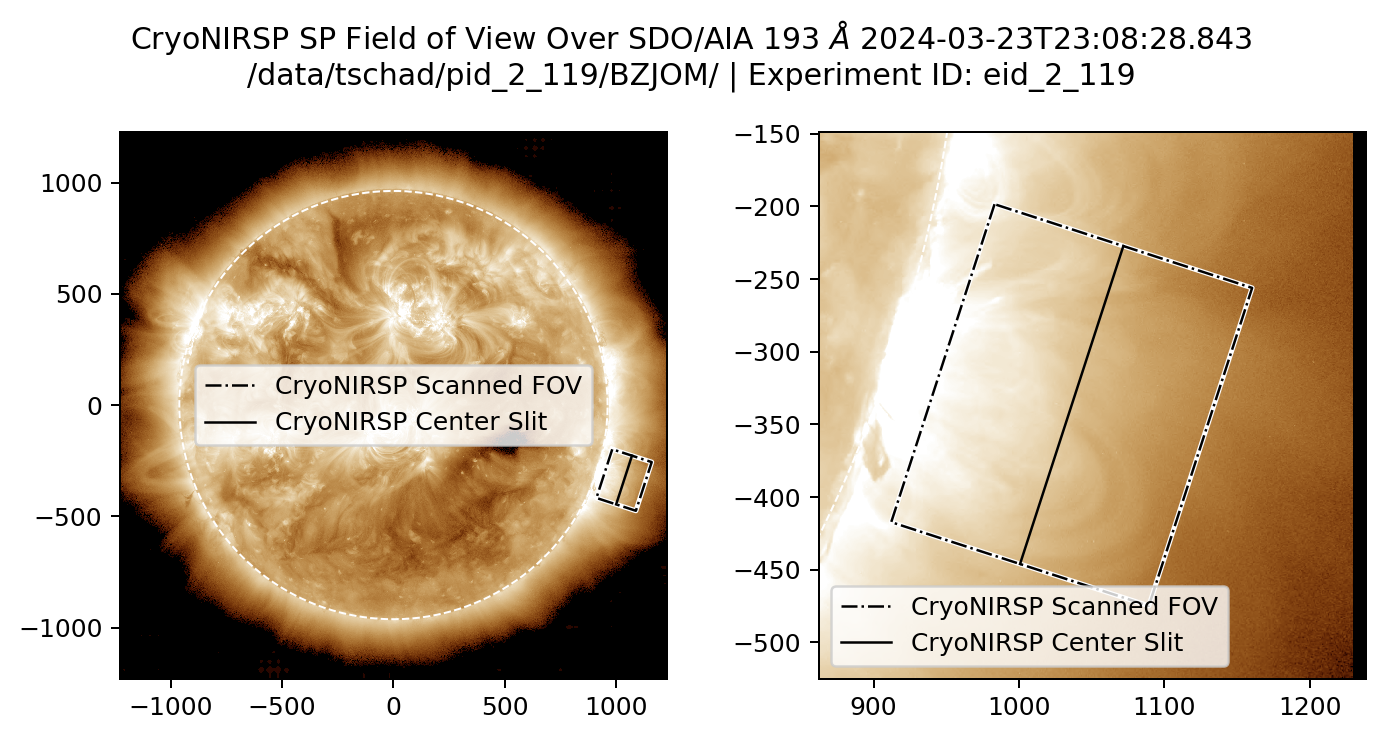

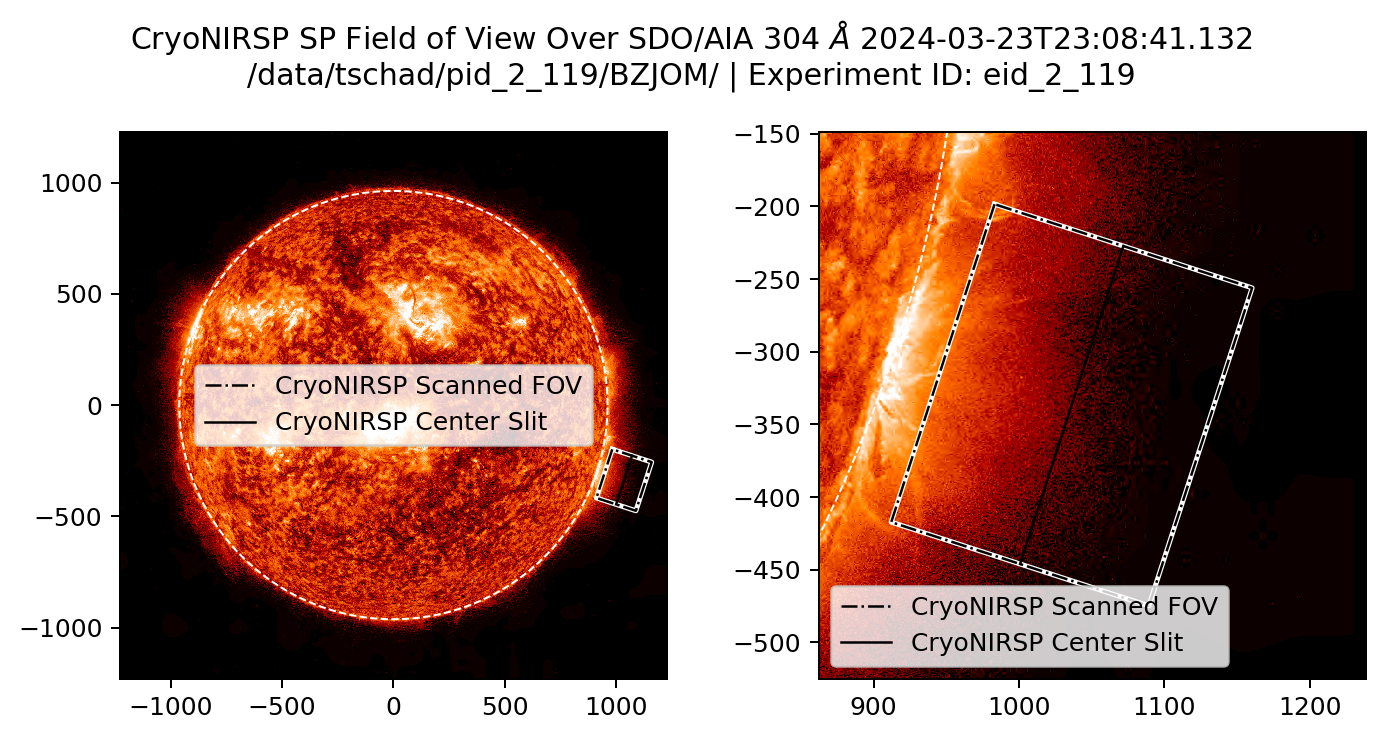

In [18]:
## Get a full disk AIA 193 images from helioviewer API 

for source in hvpy.DataSource.AIA_193,hvpy.DataSource.AIA_304,: 
    
    filepath = hvpy.save_file(hvpy.getJP2Image(date=Time(hdrs[0]['DATE-AVG']).to_datetime(), 
                                               sourceId=source), filename="~/example.jpeg",overwrite=True)  
    mm = sunpy.map.Map(filepath)  ## assumed to be rotated and centered with Solar North up. 
    ny, nx = mm.data.shape
    extaia = (mm.pixel_to_world(0*u.pix,0*u.pix).Tx.value,  mm.pixel_to_world(nx*u.pix,0*u.pix).Tx.value,
              mm.pixel_to_world(0*u.pix,0*u.pix).Ty.value,  mm.pixel_to_world(0*u.pix,ny*u.pix).Ty.value)
    
    fig,ax = plt.subplots(1,2,figsize = (8,4))
    ax = ax.flatten()
    for axi in ax: 

        ## show AIA data
        imn = axi.imshow(mm.data,extent = extaia,cmap = 'sdoaia'+ str(mm.meta['wavelnth']),norm = PowerNorm(0.65))
        imn.set_clim(np.nanpercentile(mm.data,[5,99.5]))

        ## CryoNIRSP dataset spatial bounds 
        axi.plot(spatialBounds[0],spatialBounds[1],lw = 2,color = 'white',ls = 'solid')
        axi.plot(spatialBounds[0],spatialBounds[1],lw = 1,color = 'black',ls = 'dashdot',label = "CryoNIRSP Scanned FOV")
        axi.plot(hpxyCoords[0,n_scanSteps//2,0,:],hpxyCoords[1,n_scanSteps//2,0,:],
                 lw = 1,color = 'black',ls = 'solid',label = "CryoNIRSP Center Slit")

        ## overplot solar limb 
        rsun = hdrs[0]['SOLARRAD']
        tx = np.linspace(0,2.*np.pi,500)
        axi.plot(rsun*np.cos(tx),rsun*np.sin(tx),lw = 0.8,ls = 'dashed',color = 'white')
        
        axi.set_facecolor('black')
        axi.legend()

    ## CREATE A ZOOMED IN PANEL 
    xw = spatialBounds[0].max() - spatialBounds[0].min()
    yw = spatialBounds[1].max() - spatialBounds[1].min()
    ww = np.max((xw,yw))
    ax[1].set_xlim(spatialBounds[0].min()-50,spatialBounds[0].min() + ww + 50)
    ax[1].set_ylim(spatialBounds[1].min()-50,spatialBounds[1].min() + ww + 50)
    fig.suptitle(f"CryoNIRSP SP Field of View Over SDO/AIA {mm.meta['wavelnth']} $\\AA$ {mm.meta['date-obs']}\n{dataset_directory} | Experiment ID: {hdrs[0]['EXPER_ID']}")
    fig.tight_layout()
    fig.savefig(f"./figures/dataset_{hdr_dict['DSETID'][0]}_FOV_over_SDO_AIA_ {mm.meta['wavelnth']}.png",dpi = 300)

# Load data according to use

##  Coadding all repeated measurements 

* We elect here to coadd all repeated measurements to save on the total memory of the dataset
* This also should improve SNR (depending on the number of repeated measurements)
* This is a choice, and we could also use the repeats to look for temporal variability 

In [19]:
dataset_shape   = (n_stokes,n_scanSteps,n_measAtStep,n_alongSlit,n_wv)
print("Data Set Shape: ",dataset_shape)

Data Set Shape:  (4, 51, 10, 1917, 902)


In [20]:
## data buffer setting number of measurements to 1 as we will coadd all repeats 
if n_scanSteps>1: 
    data        = np.zeros((n_stokes,n_scanSteps,1,n_alongSlit,n_wv),dtype = float)
    coadd_index = np.zeros(n_scanSteps)
else: 
    data        = np.zeros((n_stokes,1,n_measAtStep,n_alongSlit,n_wv),dtype = float)
    coadd_index = np.zeros(n_measAtStep)
print("Defined data set shape to load: ",data.shape)

Defined data set shape to load:  (4, 51, 1, 1917, 902)


In [21]:
## Reading data in and coadding the multple repeat
## This step uses multiprocessing 
def work(argin): 
    ''' work function for the parallel process'''
    n = argin  ## scan step index 
    
    img = []
    ## get Stokes I image
    img.append(fits.getdata(L1_filenames[n],ext=1).squeeze())

    ## get Stokes Q,U, and V. 
    if n_stokes>1: 
        img.append(fits.getdata(L1_filenames[n].replace('_I_','_Q_'),ext=1).squeeze())
        img.append(fits.getdata(L1_filenames[n].replace('_I_','_U_'),ext=1).squeeze())
        img.append(fits.getdata(L1_filenames[n].replace('_I_','_V_'),ext=1).squeeze())
    return hdrs[n]['CNCURSCN'],hdrs[n]['CNCMEAS'],img

ncpus = min(multiprocessing.cpu_count() , 40)
p     = multiprocessing.Pool(processes=ncpus,maxtasksperchild = 1000)
arg_array = list(range(len(hdrs)))
rs    = p.imap(work,arg_array)
p.close()

pbar = tqdm(total=len(arg_array),position = 0, leave = True)
data *= 0   ## zeroing data incase of repeated running of this cell 
coadd_index *= 0
for i,res in enumerate(rs):
    CNCURSCN,CNCMEAS,imgs = res 
    if n_scanSteps>1: 
        data[:,CNCURSCN-1,0,:,:] += np.array(imgs)
        coadd_index[CNCURSCN-1] += 1
    else:   ## THIS CASE IS MEANT TO HANDLE SIT AND STARE CASES 
        data[:,0,CNCMEAS-1,:,:] = np.array(imgs)
    pbar.update()
pbar.close()

if n_scanSteps>1: 
    data = data / coadd_index[None,:,None,None,None]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510/510 [00:14<00:00, 36.12it/s]


In [22]:
## OVERWRITE n_scanSteps to handle if sit-and-start measurement
n_scanSteps = data.shape[1]
print(f'Number of raster scan positions: {n_scanSteps}')

Number of raster scan positions: 51


## Photometric Units

* The Level 1 data values correspond to the measured intensity relative to the calibration flat field data acquired at disk center.
* A part of this calibration includes adjusting the flat field data values for the relative exposure times and fore-optics attenuation filter transmission.
* We do not at this time account for sky transparency variations between the time of the flat field and the observation data.

**More convenient units:  millionths (or ppm) of the disk center intensity**

* Here we convert to units of millionths of the solar disk center brightness, i.e. micro B(sun center). The coronal line emission emission is typically a few to 10s of millionths of the disk center spectral radiance. 
* This can be converted to photometric energy units by referencing the disk center spectral radiance of the Sun from a catalog such as Allen's Astrophysical Quanitites. For wavelengths near 1075 nm, one millionth of coronal signal corresponds to ~ 182 photons cm^-2 arcsec^-2 nm^-1 in absolute solar units. 

In [23]:
data = data*1e6

##  Rotate Q and U to align +Q with the solar radial direction 

* DKIST L1 pipeline default polarization frame has +Q oriented along Solar E-W axis (i.e. parallel to solar meridian)
* Here we find and apply the rotation angle that will align +Q with the solar radial direction.
* +U will then be 45 degrees counterclockwise from the solar radial direction as viewed towards the Sun. 

In [24]:
hpxyCoords.shape,data.shape

((2, 51, 10, 1917), (4, 51, 1, 1917, 902))

In [25]:
linpol_rotate_angle = np.arctan2(hpxyCoords[1,:,0,:],hpxyCoords[0,:,0,:])
cos2Rot = np.cos(2.*linpol_rotate_angle)[:,None,:,None]
sin2Rot = np.sin(2.*linpol_rotate_angle)[:,None,:,None]

In [26]:
## apply Mueller Matrix rotation 
dataR = np.copy(data) 
dataR[1] =  cos2Rot*data[1]  + sin2Rot *data[2]
dataR[2] = -sin2Rot*data[1]  + cos2Rot *data[2]

In [27]:
## copy rotated dataR into data variable and release dataR from memory 
data = np.copy(dataR)
del dataR

## Create some quicklooks

### Plot example spectral image

* First we create a spectral image and profile plot.  We also identify the location of the coronal line in the data to create quicklook images below.

In [28]:
## WHICH CORONAL LINE IS IN THE DATA ? 
if (1074.65>specCoords.min()) and (1074.65<specCoords.max()): 
    wvc = 1074.65  ## wavelength center of targeted coronal Fe XIII line 
    wLine = np.argmin(np.abs(specCoords - 1074.65))  ## pixel location of coronal line
    wCont = np.argmin(np.abs(specCoords - 1074.))   ## pixel location of clean continuum 
    wPhotosphericReference = (specCoords>1074.8)*(specCoords<1075.2)
elif (1079.8>specCoords.min()) and (1079.8<specCoords.max()):
    wvc = 1079.8  ## wavelength center of targeted coronal Fe XIII line 
    wLine = np.argmin(np.abs(specCoords - 1079.8)) ## pixel location of coronal line
    wCont = np.argmin(np.abs(specCoords - 1080.2)) ## pixel location of clean continuum 
    wPhotosphericReference = (specCoords>1078.)*(specCoords<1078.85)
else: 
    print('Wavelength case not handled')
    raise

print(f"Coronal line nominal center wavelength [nm]:  {wvc}")
print(f"Spectral pixel index for coronal line:        {wLine}")
print(f"Spectral pixel index for continuum reference: {wCont}")

Coronal line nominal center wavelength [nm]:  1074.65
Spectral pixel index for coronal line:        497
Spectral pixel index for continuum reference: 349


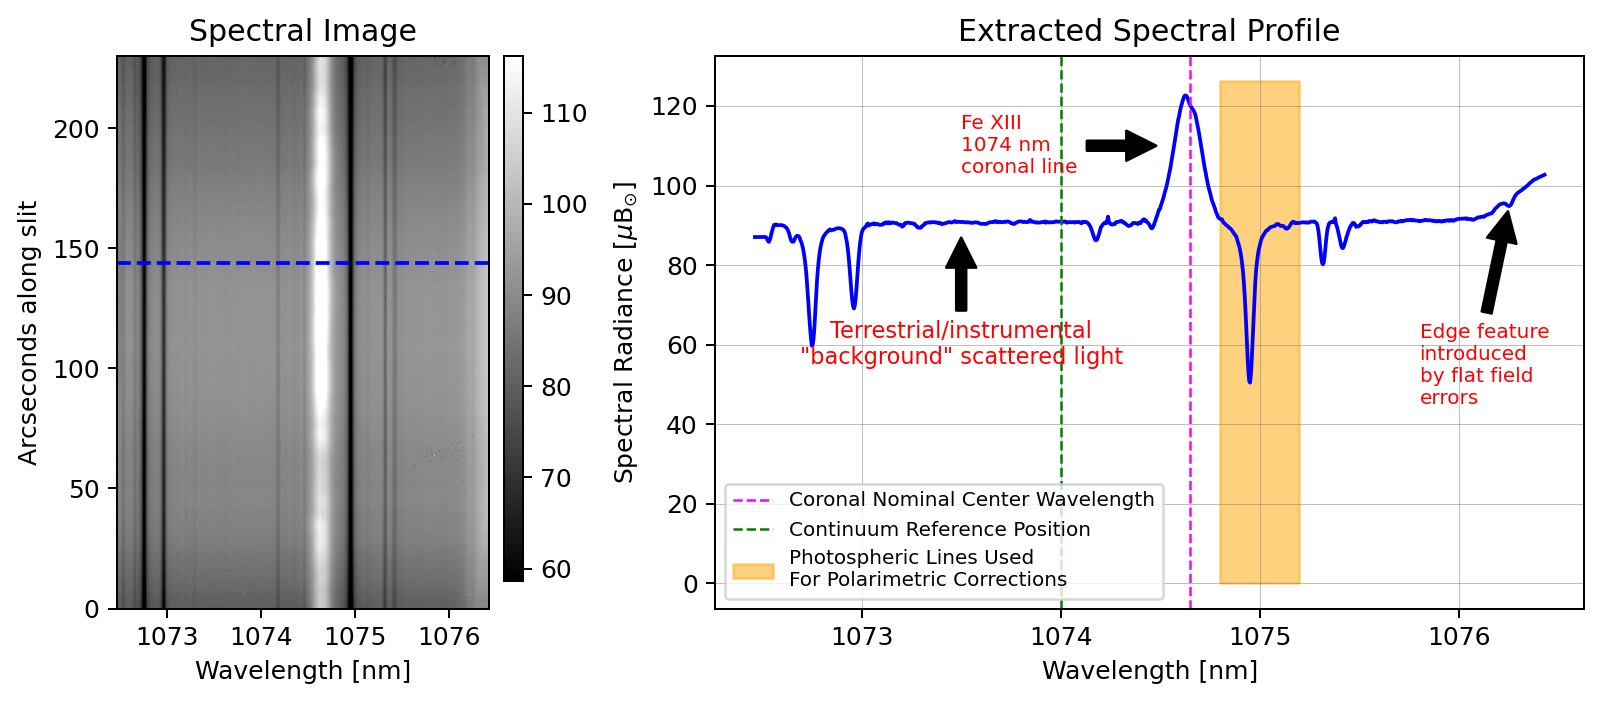

In [29]:
fig,ax = plt.subplots(1,2,figsize = (9,4),width_ratios=[0.3,0.7])
ax = ax.flatten()

im0 = ax[0].imshow(data[0,n_scanSteps//2,0,:,:],extent = (specCoords[0],specCoords[-1],0,n_alongSlit*slitSamp),aspect = 'auto')
im0.set_clim(np.nanpercentile(data[0,n_scanSteps//2,0,:,:],[1,99]))
ax[0].set_xlabel("Wavelength [nm]")
ax[0].set_ylabel("Arcseconds along slit")
ax[0].set_title("Spectral Image")

yp = 1200  ## data row to plot 
ax[0].axhline(yp*slitSamp,ls = 'dashed',color = 'blue')

cax = ax[0].inset_axes([1.04, 0.05, 0.05, 0.95], transform=ax[0].transAxes)
cbar = fig.colorbar(ax[0].get_images()[0],ax=ax[0],cax=cax)

ax[1].plot(specCoords,data[0,n_scanSteps//2,0,yp,:],color = 'blue')
ax[1].set_xlabel("Wavelength [nm]")
ax[1].set_title("Extracted Spectral Profile")
ax[1].set_ylabel(r"Spectral Radiance [$\mu$B$_{\odot}$]")
ax[1].locator_params(axis='x', nbins=6)
ax[1].grid(ls = 'solid',lw = 0.2,color = 'grey')
ax[1].axvline(wvc,label = 'Coronal Nominal Center Wavelength',color = 'magenta',lw = 1,ls = 'dashed')
ax[1].axvline(specCoords[wCont],label = 'Continuum Reference Position',color = 'green',lw = 1,ls = 'dashed')

w0 = specCoords[wPhotosphericReference][0]
w1 = specCoords[wPhotosphericReference][-1]
ax[1].fill_between([w0,w1],ax[1].get_ylim()[1]+np.zeros(2),color = 'orange',alpha = 0.5,label = "Photospheric Lines Used\nFor Polarimetric Corrections")


## Annotate some known errors
ax[1].annotate('Edge feature\nintroduced\nby flat field\nerrors', (1076.25,95.),(1075.8,45.),color ='red',
               fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05,lw = 1))
ax[1].annotate('Fe XIII\n1074 nm\ncoronal line', (1074.5,110),(1073.5,110.),color='red',
               fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05,lw = 1),va='center')
ax[1].annotate('Terrestrial/instrumental\n"background" scattered light', (1073.5,88),(1073.5,60.),color = 'red',
               fontsize = 9, arrowprops=dict(facecolor='black', shrink=0.05,lw = 1),ha='center',va='center')

ax[1].legend(fontsize = 8,loc = 'lower left')
fig.tight_layout()
fig.savefig(f"./figures/dataset_{hdr_dict['DSETID'][0]}_example_line_profile.png",dpi = 300)

### Level 1 Stokes Spectral Images

* Here we look at the full Stokes spectra at a single raster slit position.
* At this point, there is **residual polarimetric crosstalk** in the Stokes data that will need to be corrected with ad hoc methods (see, e.g., Schad et al. 2022). 

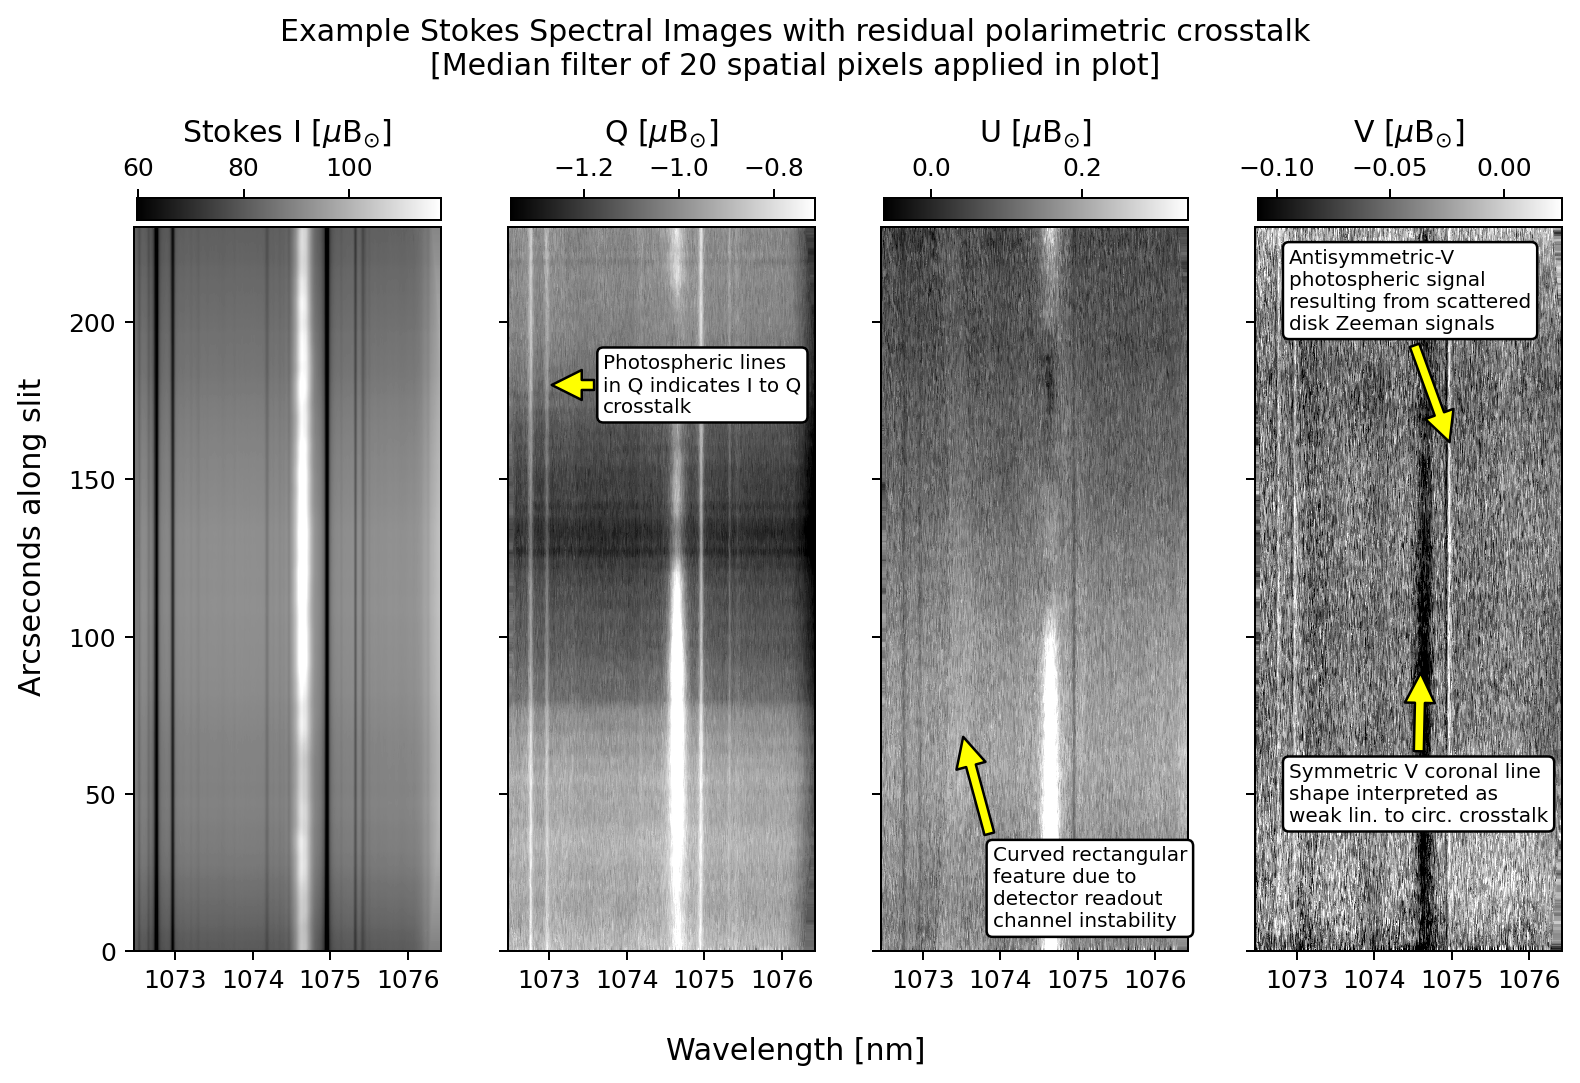

In [30]:
fig,ax = plt.subplots(1,4,figsize = (9,6),sharex=True,sharey=True)
ax = ax.flatten()

labels = 'Stokes I','Q','U','V'
for n in range(4):
    img2show = ndimage.median_filter(data[n,n_scanSteps//2,0,:,:],(20,1))
    imn = ax[n].imshow(img2show,extent = (specCoords[0],specCoords[-1],0,n_alongSlit*slitSamp),aspect = 'auto')
    imgMin,imgMed,imgMax = np.nanpercentile(img2show,[1,50,99]) 
    imn.set_clim(imgMed - 0.5*(imgMax-imgMin),imgMed + 0.5*(imgMax-imgMin))
    ax[n].set_title(labels[n] + r' [$\mu$B$_{\odot}$]')

for axi in ax: 
    cax = axi.inset_axes([0.01, 1.01, 0.99, 0.03], transform=axi.transAxes)
    cbar = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax,location = 'top')

fig.supxlabel("Wavelength [nm]")
fig.supylabel("Arcseconds along slit")

bbox = dict(boxstyle="round", fc="white")
ax[1].annotate("Photospheric lines\nin Q indicates I to Q\ncrosstalk", (1073.,180),(1073.7,180.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='left',va='center')
ax[2].annotate("Curved rectangular\nfeature due to\ndetector readout\nchannel instability", (1073.5,70),(1073.9,20.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='left',va='center')
ax[3].annotate("Symmetric V coronal line\nshape interpreted as\nweak lin. to circ. crosstalk", (1074.6,90),(1072.9,50.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='left',va='center')
ax[3].annotate("Antisymmetric-V\nphotospheric signal\nresulting from scattered\ndisk Zeeman signals", (1075,160),(1072.9,210.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='left',va='center')
fig.suptitle("Example Stokes Spectral Images with residual polarimetric crosstalk\n[Median filter of 20 spatial pixels applied in plot]")
fig.tight_layout()
fig.savefig(f"./figures/dataset_{hdr_dict['DSETID'][0]}_example_stokes_spectral_images_Level1.png",dpi = 300)

### Quicklook raster maps of the line and background intensities

In [31]:
print(f"Data shape reminder:  {data.shape}")
print(f"Pixel near coronal line center: {wLine}")
print(f"Pixel in background continuum: {wCont}")
imgLine = np.nanmedian(data[0,:,:,:,(wLine-3):(wLine+3)],axis=(1,3))  ## median of repeats and 6 wavelengths 
imgCont = np.nanmedian(data[0,:,:,:,(wCont-3):(wCont+3)],axis=(1,3))

Data shape reminder:  (4, 51, 1, 1917, 902)
Pixel near coronal line center: 497
Pixel in background continuum: 349


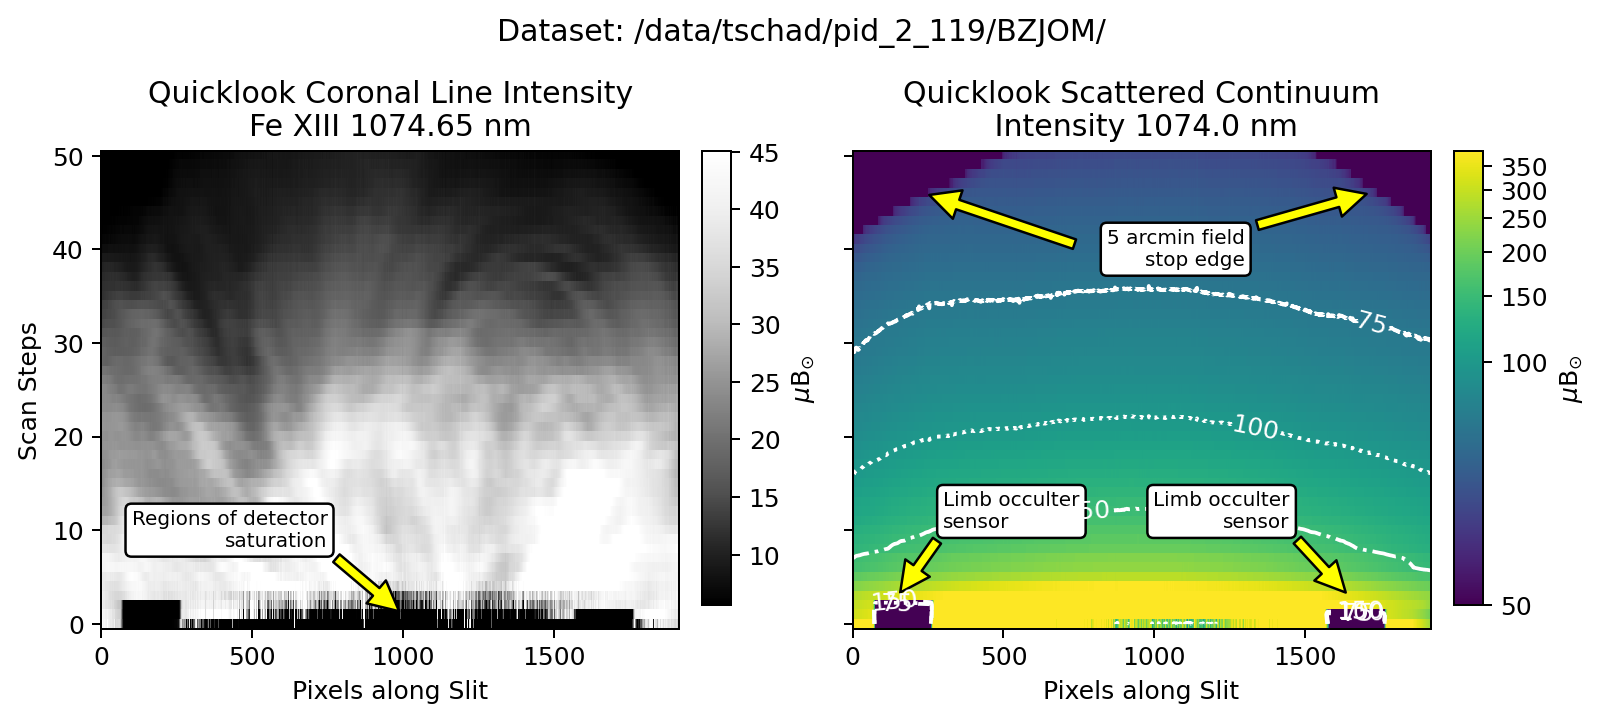

In [32]:
fig,ax = plt.subplots(1,2,figsize = (9,4),sharex=True,sharey=True)
ax = ax.flatten()
cmap= plt.get_cmap('Greys_r')
im0 = ax[0].imshow((imgLine-imgCont),aspect=stepWidth/slitSamp,cmap = cmap)
im1 = ax[1].imshow(imgCont ,aspect=stepWidth/slitSamp,cmap = 'viridis',norm = PowerNorm(0.3))
CS = ax[1].contour(imgCont,[75,100,150],colors = 'white',linestyles = ('dashed','dotted','dashdot'))
ax[1].clabel(CS, CS.levels, inline=True, fontsize=10)

im0.set_clim(np.nanpercentile(imgLine-imgCont,[5,95]))
im1.set_clim(np.nanpercentile(imgCont,[5,95]))
ax[0].set_title(f"Quicklook Coronal Line Intensity\nFe XIII {np.round(specCoords[wLine],2)} nm")
ax[1].set_title(f"Quicklook Scattered Continuum\n Intensity {np.round(specCoords[wCont],2)} nm")
cbars = []
for axi in ax:
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    cbar1.set_label("$\mu$B$_{\odot}$")
    cbars.append(cbar1)
    axi.set_xlabel("Pixels along Slit")
ax[0].set_ylabel("Scan Steps")
fig.suptitle(f"Dataset: {dataset_directory}")

ax[0].annotate("Regions of detector\nsaturation", (1000.,1),(750.,10.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='right',va='center')

ax[1].annotate("Limb occulter\nsensor", (150.,3),(300.,12.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='left',va='center')
ax[1].annotate("Limb occulter\nsensor", (1645.,3),(1450.,12.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='right',va='center')
ax[1].annotate("5 arcmin field\nstop edge", (1726.,46.1),(1300.,40.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='right',va='center')
ax[1].annotate("", (226.,46.1),(785.,40.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='right',va='center')
fig.tight_layout()
fig.savefig(f"./figures/dataset_{hdr_dict['DSETID'][0]}_quicklook_line_and_background_I_maps.png",dpi = 300)

#### View spectra near solar limb where saturation occurs

* The regions of detector saturation above occur near scan steps <5, which are those when the slit, which was parallel to the solar limb, was closest to the solar limb.
* The data in these regions is compromised by the detector saturation and should not be used.

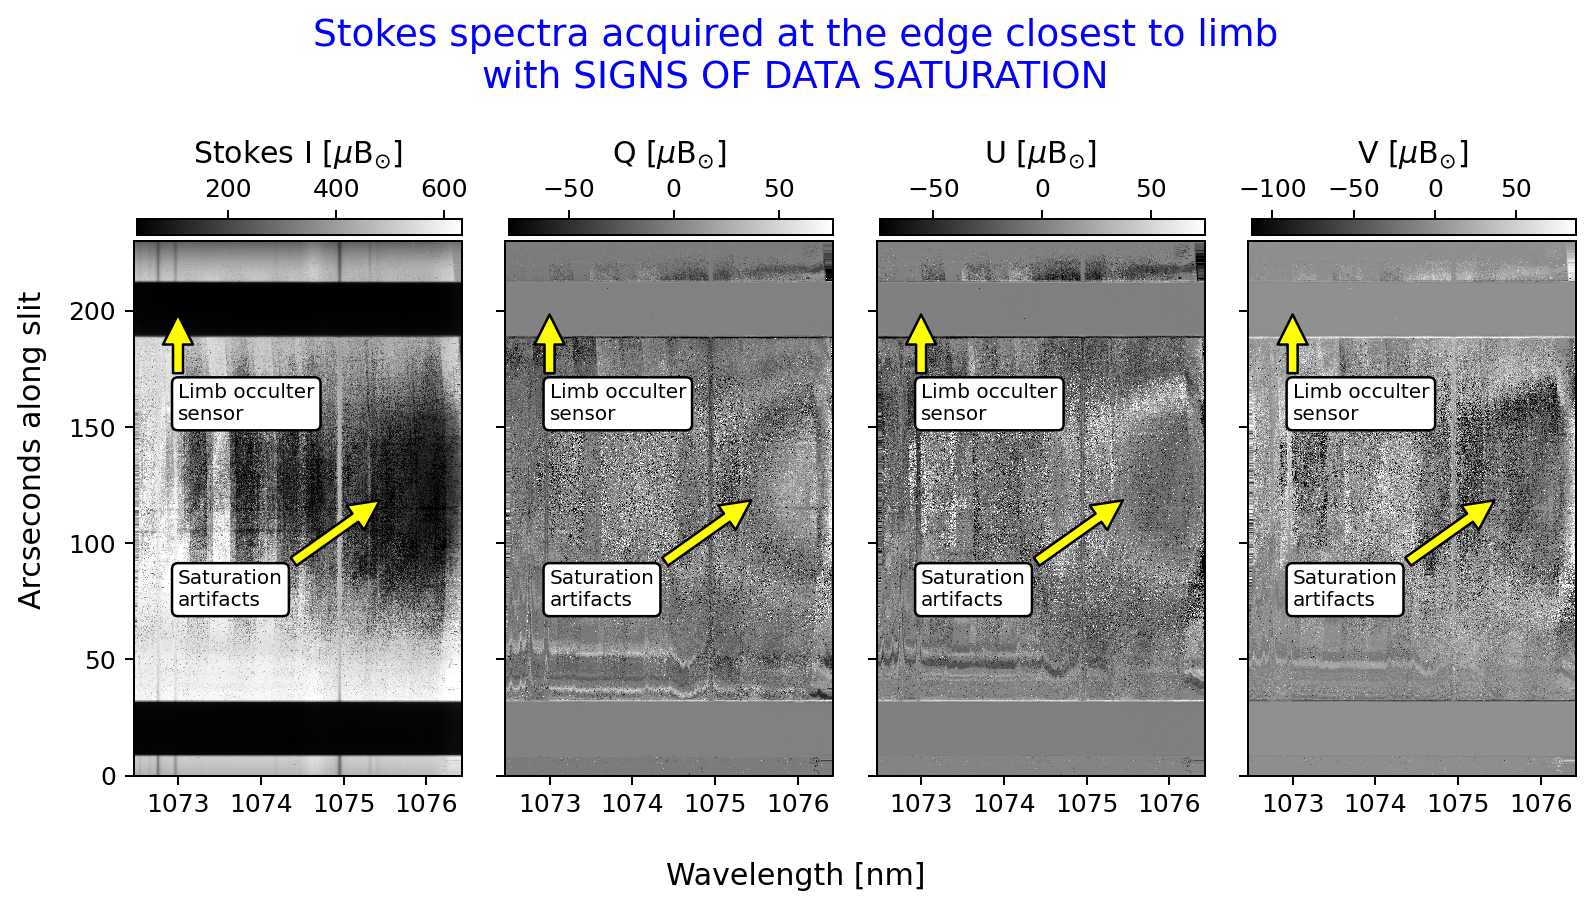

In [33]:
fig,ax = plt.subplots(1,4,figsize = (9,5),sharex=True,sharey=True)
ax = ax.flatten()

labels = 'Stokes I','Q','U','V'
for n in range(4):
    imn = ax[n].imshow(data[n,0,0,:,:],extent = (specCoords[0],specCoords[-1],0,n_alongSlit*slitSamp),aspect = 'auto')
    imn.set_clim(np.nanpercentile(data[n,0,0,:,:],[1,99]))
    ax[n].set_title(labels[n] + r' [$\mu$B$_{\odot}$]')

for axi in ax: 
    cax = axi.inset_axes([0.01, 1.01, 0.99, 0.03], transform=axi.transAxes)
    cbar = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax,location = 'top')

for axi in ax: 
    axi.annotate("Limb occulter\nsensor", (1073.,200),(1073.,160.),bbox = bbox,
                fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='left',va='center')
    axi.annotate("Saturation\nartifacts", (1075.5,120),(1073.,80.),bbox = bbox,
                   fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='left',va='center')

fig.supxlabel("Wavelength [nm]")
fig.supylabel("Arcseconds along slit")
fig.suptitle("Stokes spectra acquired at the edge closest to limb\nwith SIGNS OF DATA SATURATION",fontsize = 15,color = 'blue')
fig.tight_layout()
fig.savefig(f"./figures/dataset_{hdr_dict['DSETID'][0]}_example_saturated_spectra.png",dpi = 300)

### Quicklook raster maps of Stokes Signals

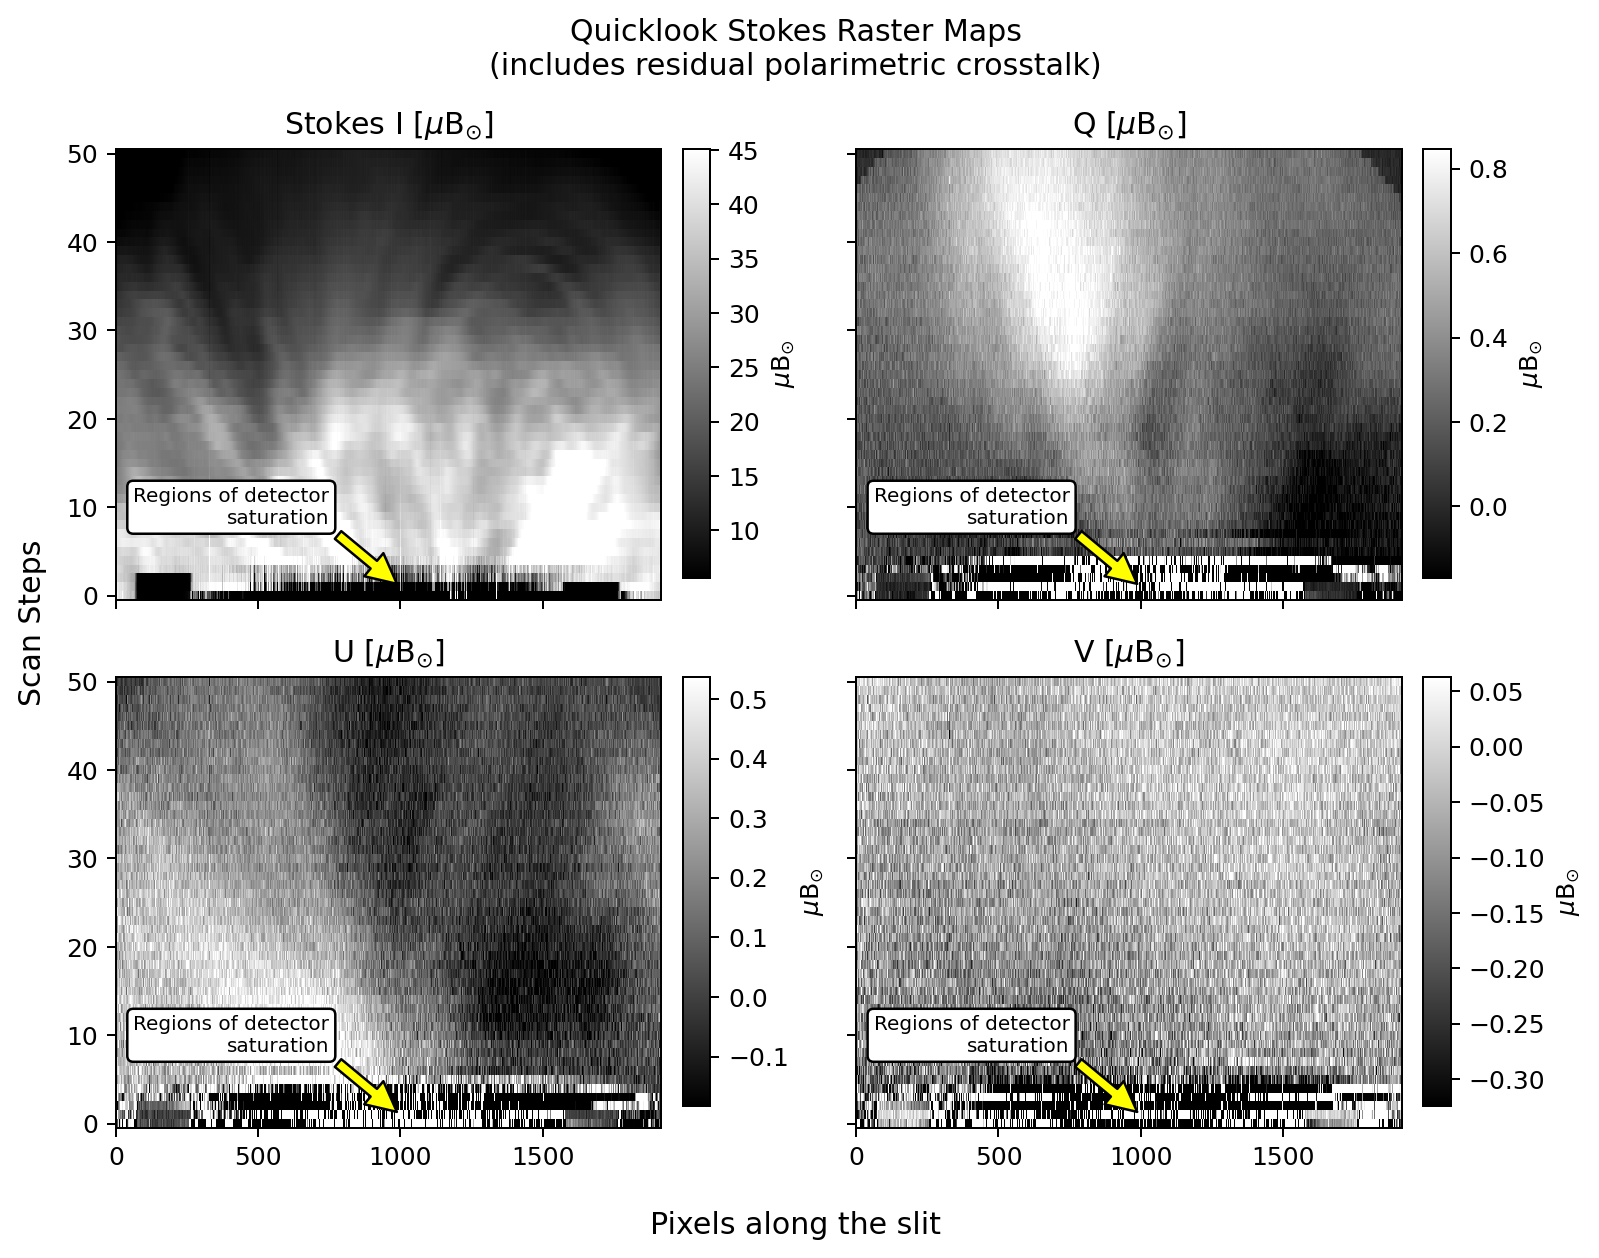

In [34]:
fig,ax = plt.subplots(2,2,figsize = (9,7),sharex=True,sharey=True)
ax = ax.flatten()

for n in range(4): 
    imgLine = np.nanmedian(data[n,:,:,:,(wLine-3):(wLine+3)],axis=(1,3))  ## median of repeats and 6 wavelengths 
    imgCont = np.nanmedian(data[n,:,:,:,(wCont-3):(wCont+3)],axis=(1,3))
    imn = ax[n].imshow((imgLine-imgCont),aspect=stepWidth/slitSamp)
    imn.set_clim(np.nanpercentile(imgLine-imgCont,[5,95]))
    ax[n].set_title(labels[n] + r' [$\mu$B$_{\odot}$]')
    ax[n].annotate("Regions of detector\nsaturation", (1000.,1),(750.,10.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='right',va='center')

for axi in ax:
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    cbar1.set_label("$\mu$B$_{\odot}$")

fig.supylabel("Scan Steps")
fig.supxlabel("Pixels along the slit")
fig.suptitle("Quicklook Stokes Raster Maps\n(includes residual polarimetric crosstalk)")
fig.tight_layout()    
fig.savefig(f"./figures/dataset_{hdr_dict['DSETID'][0]}_example_Stokes_signal_maps_Level1.png",dpi = 300)

# Prepare for spectral line fitting 

* The goal in this section is to extract line fit parameters pertaining to the Fe XIII Stokes spectral profiles.
* Due to the background scattered light amplitude, we must model the effects of the scattered photospheric light and the telluric absorption on the observed profiles, in addition to various instrumental response parameters (e.g. resolving power) 
* We will also implement a correction for the polarized crosstalk in the data using an ad-hoc method as partially described in Schad et al. (2022). 

In [35]:
## DOWNLOAD THE ATLAS FILES IS NOT ALREADY IN DIRECTORY
if not os.path.exists('./atlases/solar_merged_20200720_600_33300_100.out.gz'): 
    os.chdir('./atlases/')
    !wget -nc --no-parent https://github.com/tschad/dkist_telluric_atlas/raw/main/atlases/telluric_atlas_mainMol_USstd_wv_air_angstrom_v20240307.npy
    !wget -nc --no-parent https://github.com/tschad/dkist_telluric_atlas/raw/main/atlases/telluric_atlas_mainMol_USstd_CO2_416ppm-Base_3km-PWV_3__mm-Airmass_1___v20240307.npy
    !wget -nc --no-parent https://mark4sun.jpl.nasa.gov/toon/solar/solar_merged_20200720_600_33300_100.out.gz
    os.chdir('../')

## Load spectral atlases for modeling

* Here we load the telluric absorption and solar atlases that we will use for the fitting.  The choice to use these particular atlases is open for discussion.
* The telluric atlas is sourced from [Tom Schad's DKIST Telluric Atlas](www.github.com/tschad/dkist_telluric_atlas), which is a repository that shows how to calculate synthetic terrestrial spectra using the HITRAN database of molecular properties and a model of the Earth's atmosphere (i.e, temperature, pressure, molecular concentrations, etc.)
  * The model used contains 3 mm of precipitable water vapor above the telescope.  Water absorption is important near the 1 micron lines, and can be quite variable day to day. Some days there may be a lot of water, and others, its almost negligble.
* The solar atlas is the "Solar Pseudo-Transmittance Spectrum" generated by Geoffrey C. Toon, as part of the "Solar line list gor GGG2014" within the TCCON project.  For more details, see https://mark4sun.jpl.nasa.gov/toon/solar/solar_spectrum.html.

In [36]:
## LOAD THE TELLURIC ATLAS 
wvair_telluric = np.load('./atlases/telluric_atlas_mainMol_USstd_wv_air_angstrom_v20240307.npy')  /10.                  ## converting to nm 
trans_telluric  = np.load('./atlases/telluric_atlas_mainMol_USstd_CO2_416ppm-Base_3km-PWV_3__mm-Airmass_1___v20240307.npy')

## LOAD SOLAR ATLAS
def vac2air(wave_vac):
    """ Converts wavelengths from vacuum to air-equivalent """
    wave_air = np.copy(wave_vac)
    ww  = (wave_vac >= 2000) 
    sigma2 = (1e4 / wave_vac[ww])**2 
    n = 1 + 0.0000834254 + 0.02406147 / (130 - sigma2) + 0.00015998 / (38.9 - sigma2)
    wave_air[ww] = wave_vac[ww] / n
    return wave_air
# data is in wavenumber [cm^-1] in vacuum, it needs to be in wavelength in air. 
dc   = np.loadtxt('./atlases/solar_merged_20200720_600_33300_100.out.gz',skiprows =3)  ## disk integrate  -- 100
wvair_solar = vac2air(1e8/dc[:,0])[::-1]   / 10.
atlas_solar = dc[:,1][::-1]    

## INTERPOLATE ATLASES ONTO THE SPECTRAL AXIS OF THE CRYONIRSP DATA 
trans_telluric = np.interp(specCoords,wvair_telluric,trans_telluric)
atlas_solar = np.interp(specCoords,wvair_solar,atlas_solar)

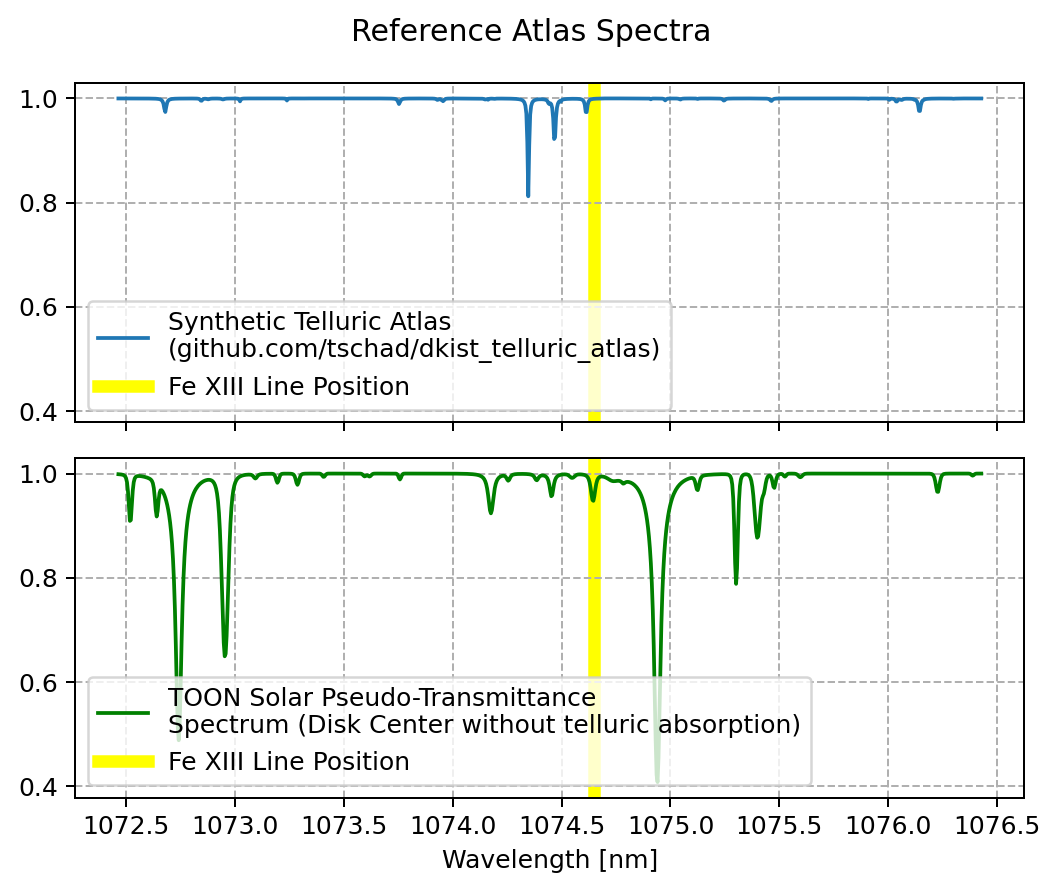

In [37]:
## Plot atlases
fig,ax = plt.subplots(2,1,figsize = (6,5),sharex=True,sharey=True)
ax[0].plot(specCoords,trans_telluric,label = "Synthetic Telluric Atlas\n(github.com/tschad/dkist_telluric_atlas)")
ax[1].plot(specCoords,atlas_solar,'g',label = 'TOON Solar Pseudo-Transmittance\nSpectrum (Disk Center without telluric absorption)')
fig.suptitle("Reference Atlas Spectra")
ax[1].set_xlabel("Wavelength [nm]")
for axi in ax: 
    axi.axvline(wvc,lw = 5,color = 'yellow',zorder = -5,label = 'Fe XIII Line Position')
    axi.legend(fontsize = 10,loc = 'lower left')
    axi.grid(ls = 'dashed')
fig.tight_layout()
fig.savefig(f"./figures/reference_telluric_solar_atlas_bandpass.png",dpi = 300)

### Define some numba functions needed for later

* Fitting all of the spectral profiles can benefit from accelerated forward functions.  Here numba is used, but the functions can easily be changed to not use numba by removing the decorators.

In [38]:
@njit(fastmath=True)
def gaussian_filter1d_numba(input_array, sigma):
    ''' Applies a Gaussian 1D convolution to 1d array '''
    # Generate Gaussian kernel
    radius = int(3 * sigma + 0.5)  ## USING ONLY 3 STD DEVS FOR SPEED
    x = np.arange(-radius, radius + 1)
    gaussian_kernel = np.exp(-0.5 * (x / sigma) ** 2)
    gaussian_kernel /= gaussian_kernel.sum()
    output = np.zeros_like(input_array)
    for i in range(radius,len(input_array)-radius):
        for k in range(len(gaussian_kernel)):
            j = i + k - radius
            output[i] += input_array[j] * gaussian_kernel[k]
    ## edge treatment
    output[:radius] = input_array[:radius]
    output[(-radius):] = input_array[(-radius):]
    return output

@njit(fastmath=True)
def gradient_1d(arr,spacing=1.0):
    ''' Calculated the 1d gradient of an array (replaces np.gradient)'''
    n = len(arr)
    grad = np.zeros(n)
    # Forward difference for the first element
    grad[0] = (arr[1] - arr[0]) / spacing
    # Central difference for the interior elements
    for i in range(1, n - 1):
        grad[i] = (arr[i + 1] - arr[i - 1]) / (2.0 * spacing)
    # Backward difference for the last element
    grad[n - 1] = (arr[n - 1] - arr[n - 2]) / spacing
    return grad

# Spectroscopic (Stokes-I) Line Fitting

* We now start line fitting by considering the spectroscopic case first; that is, we ignore the polarized states and fit only Stokes I.
* The model below seeks to fit a Gaussian line profile to the coronal line emission while modeling the blended solar and telluric components. 

## Create a fitting function 

In [39]:
## Define spectral weights to apply
Iwgts = np.ones_like(specCoords)
## ....set edge weights to zero to mitigate flat field artifacts
Iwgts[0:75] = 0
Iwgts[(-75):] = 0
## ...increase weights in vicintiy of the coronal line to bias the fit to this region 
Iwgts[(specCoords>(wvc-0.5))*(specCoords<(wvc+0.5))] = 5.
## ...normalize weights 
Iwgts = Iwgts/np.max(Iwgts)

wv_mean = specCoords.mean()
dwv = np.abs(specCoords[0]-specCoords[1])

@njit(fastmath=True)
def modelStokesI(para): 
    ''' Forward model of spectral line observation assuming single Gaussian profile for coronal line 
    
        Parameters within para input list are: 

        lineAmp    -- Gaussian function amplitude of the coronal line in micro-B
        lineCenWv  -- Coronal line center wavelength (including Doppler shift) in nm 
        lineWidth  -- Gaussian line width in nm  
        LSF_RPOW   -- Resolving power of line spread function 
        opac       -- An opacity factor to modify total telluric line absorpance 
        velS       -- Velocity shift of solar atlas relative to observed spectrum
        velT       -- Velocity shift of telluic atlas relative to observed spectrum
        strayfrac  -- Additional scalar fraction of straylight within spectrograph (i.e. the "veil" component)
        icont      -- Amplitude of the background continuum intensity (dominated by scattered light)
    
    '''
    
    lineAmp,lineCenWv,lineWidth,LSF_RPOW,opac,velS,velT,strayfrac,icont,= para 
    
    ## coronal line
    coronal_line = lineAmp*np.exp(-(specCoords-lineCenWv)**2/(2*lineWidth**2)) 
    
    ## telluric transmission and scattered photospheric light contributions
    ftsTmod = np.interp(specCoords,specCoords + velT/3e5*wv_mean,trans_telluric**opac)
    ftsSmod = np.interp(specCoords,specCoords + velS/3e5*wv_mean,atlas_solar)
    ftsmod  = ftsTmod * ftsSmod
    
    ## add straylight and scale for amplitude
    ftsmod = icont * (ftsmod + strayfrac) / (1. + strayfrac)

    ## combine components
    ifit = ftsmod + (coronal_line * ftsTmod)     

    ## Gaussian convolution of the FTS atlast
    kern_pix  = (wvc / LSF_RPOW) / 2.3548200450309493 / dwv
    ifit = gaussian_filter1d_numba(ifit, kern_pix) 
    
    return ifit

@njit(fastmath=True)
def objFuncStokesI(para,ii): 
    ''' Objective function -- Reduced Chi-Squared Statistic ''' 
    ifit = modelStokesI(para)
    ires = np.sum((ii-ifit)**2  * Iwgts) / np.sum(Iwgts)
    return ires

## Example fit using differential evolution 

* For optimization, we use differential evolution (a genetic algorithm), which is less likely to get stuck in local minimum, but does take longer computational times.

In [ ]:
%%time 
yp = n_alongSlit//2     ## select a pixel along the slit for an example 
step = n_scanSteps//2   ## select a raster step to use 
step,yp = 39,455
## get observation -- here we take a local spatial median of 10 pixels along the slit 
## 10 pixels at 0.12 arcsec per pixel ==> 1.2 
ii = np.nanmedian(data[0,step,0,(yp-5):(yp+5),:],axis=0)

## Bounds of the model variables
pnames = 'lineAmp','lineCew','lineWid','LSF_FWHM','opacity','velS','velT','strayfrac','icont',
bounds = [(0,2*(np.max(ii)-np.nanmedian(ii))),                            ## line ampltitude in millionths 
          (wvc*(1-10/3e5),wvc*(1.+10/3e5)),  ## coronal line center wavelength [nm]
          (0.055,0.1),                       ## coronal Gaussian line width [nm]
          (30000,70000),                  ## Resolving power of line spread function 
          (0.05,2),                          ## telluric opacity factor 
          (0,3),                             ## velocity shift in km/s for the solar atlas  [TUNED ACCORDING TO PRELIMINARY FITS]
          (-3,0),                            ## velocity shift in km/s for the telluric atlas [TUNED ACCORDING TO PRELIMINARY FITS]
          (0.,0.5),                          ## Spectrograph constant straylight fraction 
          (np.nanmedian(ii)-3,np.nanmedian(ii)+3)]  ## Amplitude of the background scattered light in millionths      

def callBFunc(intermediate_result):
    ''' callback function to stop iterations once objective function is <0.3''' 
    return intermediate_result.fun < 0.12

res = differential_evolution(objFuncStokesI,bounds,args = (ii,),disp = True,tol=1.e-14,maxiter = 75,
                             popsize = 1,polish = True,callback=callBFunc)

In [41]:
pnames = 'lineAmp','lineCew','lineWid','LSF_RPOW','opacity','velS','velT','strayfrac','icont',
print(f"Objective function final value: {res.fun}")
print("Parameter values...")
for n in range(len(res.x)): 
    print(f"{str(n).ljust(6)}  {pnames[n].rjust(10)}:  {res.x[n]:10.4f}    Bounds (Min): {bounds[n][0]:9.3f}   (Max): {bounds[n][1]:9.3f}")
## Calculate fitted profile
ifit = modelStokesI(res.x)

Objective function final value: 0.08345276284435044
Parameter values...
0          lineAmp:     11.5670    Bounds (Min):     0.000   (Max):    21.413
1          lineCew:   1074.6398    Bounds (Min):  1074.614   (Max):  1074.686
2          lineWid:      0.0673    Bounds (Min):     0.055   (Max):     0.100
3         LSF_RPOW:  47730.5766    Bounds (Min): 30000.000   (Max): 70000.000
4          opacity:      0.1609    Bounds (Min):     0.050   (Max):     2.000
5             velS:      1.8904    Bounds (Min):     0.000   (Max):     3.000
6             velT:     -1.7651    Bounds (Min):    -3.000   (Max):     0.000
7        strayfrac:      0.1116    Bounds (Min):     0.000   (Max):     0.500
8            icont:     69.8262    Bounds (Min):    66.638   (Max):    72.638


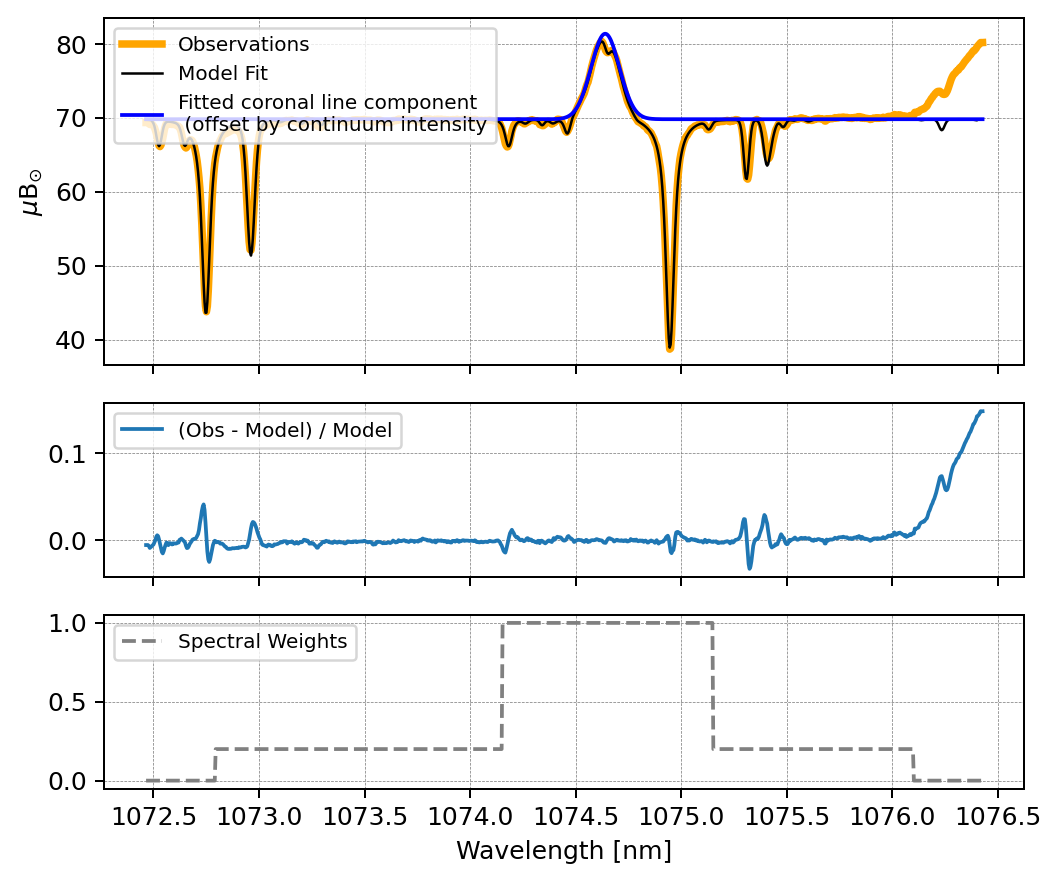

In [42]:
## Plot line fits 
fig,ax = plt.subplots(3,1,figsize = (6,5),sharex=True,height_ratios=[2,1,1])
ax[0].plot(specCoords,ii,lw = 3,color = 'orange',label = 'Observations')

lineAmp,lineCenWv,lineWidth = res.x[0:3]
icont = res.x[-1]
coronal_line = icont+ lineAmp*np.exp(-(specCoords-lineCenWv)**2/(2*lineWidth**2)) 
ax[0].plot(specCoords,ifit,lw = 1,color = 'black',label = 'Model Fit')
ax[0].plot(specCoords,coronal_line,color = 'blue',label = "Fitted coronal line component\n (offset by continuum intensity")
ax[1].plot(specCoords,(ii-ifit)/ifit,label = '(Obs - Model) / Model')
ax[2].plot(specCoords,Iwgts,ls = 'dashed',color = 'grey',label = 'Spectral Weights')
ax[2].set_xlabel("Wavelength [nm]")
ax[0].set_ylabel(r"$\mu$B$_{\odot}$")
for axi in ax: 
    axi.legend(loc = 'upper left',fontsize = 8)
    axi.grid(ls = 'dashed',lw = 0.3,color = 'grey')
fig.tight_layout()
fig.savefig(f"./figures/example_StokesI_line_fits.png",dpi = 300)

## Do spectroscopy fits across raster map

* We stride over the data to not fit all of the data in one go (this cuts down on the time to create a map).

In [43]:
def callBFunc(intermediate_result):
    return intermediate_result.fun < 0.12

def work(argin): 
    """ function defining what work is carried out by the parallel process """ 
    step,yp = argin 

    ## Get observed Stokes I spectra at this step and yp (i.e. pixel along y or the slit)
    ii = np.nanmedian(data[0,step,0,(yp-5):(yp+5),:],axis=0)  ## 10 pixel median 

    bounds = [(0,2*(np.max(ii)-np.nanmedian(ii))),                            ## line ampltitude in millionths 
          (wvc*(1-10/3e5),wvc*(1.+10/3e5)),  ## coronal line center wavelength [nm]
          (0.055,0.1),                       ## coronal Gaussian line width [nm]
          (37000,65000),                  ## Resolving power of line spread function 
          (0.05,0.7),                          ## telluric opacity factor 
          (0,3),                             ## velocity shift in km/s for the solar atlas  [TUNED ACCORDING TO PRELIMINARY FITS]
          (-3,0),                            ## velocity shift in km/s for the telluric atlas [TUNED ACCORDING TO PRELIMINARY FITS]
          (0.,0.5),                          ## Spectrograph constant straylight fraction 
          (np.nanmedian(ii)-3,np.nanmedian(ii)+3)]  ## Amplitude of the background scattered light in millionths      
    
    try: 
        res = differential_evolution(objFuncStokesI,bounds,args = (ii,),disp = False,tol=1.e-14,maxiter = 150,popsize = 1,polish = True,callback=callBFunc)
        return step,yp,res.x,res.fun
    except:
        return step,yp,np.zeros(len(bounds)),np.nan
    return 

In [44]:
%%time   
## View time for one fit 
step = n_scanSteps//2
yp   = n_alongSlit//2
step_out,yp_out,result_out,objfun_out = work((step,yp))
print(objfun_out)

0.1873535348581209
CPU times: user 282 ms, sys: 80 µs, total: 282 ms
Wall time: 282 ms


In [45]:
## INITIAL FITTING EVERY 10 PIXELS ALONG THE SLIT 
pixel_stride = 10

if 0:   ## set to 1 to actually run all fits (takes a bit of time) 
    ncpus = min(multiprocessing.cpu_count() , 70)
    p     = multiprocessing.Pool(processes=ncpus,maxtasksperchild = 1000)
    arg_array = []
    for step in range(0,data.shape[1]): 
        for yp in range(5,data.shape[3]-5,pixel_stride): 
            arg_array.append((step,yp))

    rs    = p.imap(work,arg_array)
    p.close()
    
    pbar = tqdm(total=len(arg_array),position = 0, leave = True)

    fit_results = np.zeros((data.shape[1],data.shape[3],len(bounds)+1),dtype = float)
    
    for i,res in enumerate(rs):
        step,yp,result_out,objfun_out = res 
        fit_results[step,yp,:(-1)] = result_out 
        fit_results[step,yp,-1] = objfun_out  
        pbar.update()
    pbar.close()

    np.save(output_directory + 'stokesI_line_fit_results.npy',fit_results)

else:
    fit_results = np.load(output_directory + 'stokesI_line_fit_results.npy')

### Create figure showing example fitted spectrum for one step

In [46]:
step = 24
ii_obs = ndimage.median_filter(data[0,step,0,:,:],(10,1))[5::10]   ## OBSERVED
ii_fit = np.zeros_like(data[0,step,0,:,:])  ## REGENERATE FITS 
for yp in range(5,data.shape[3]-5,pixel_stride): 
    ii_fit[yp,:] = modelStokesI(fit_results[step,yp,:(-1)])
ii_fit = ii_fit[5::10]

/tmp/ipykernel_1660469/486432010.py:7: RuntimeWarning: divide by zero encountered in divide
  im2 = ax[2].imshow((ii_obs-ii_fit)/ii_fit,extent = (specCoords[0],specCoords[-1],0,n_alongSlit*slitSamp),aspect = 'auto',cmap = 'viridis')


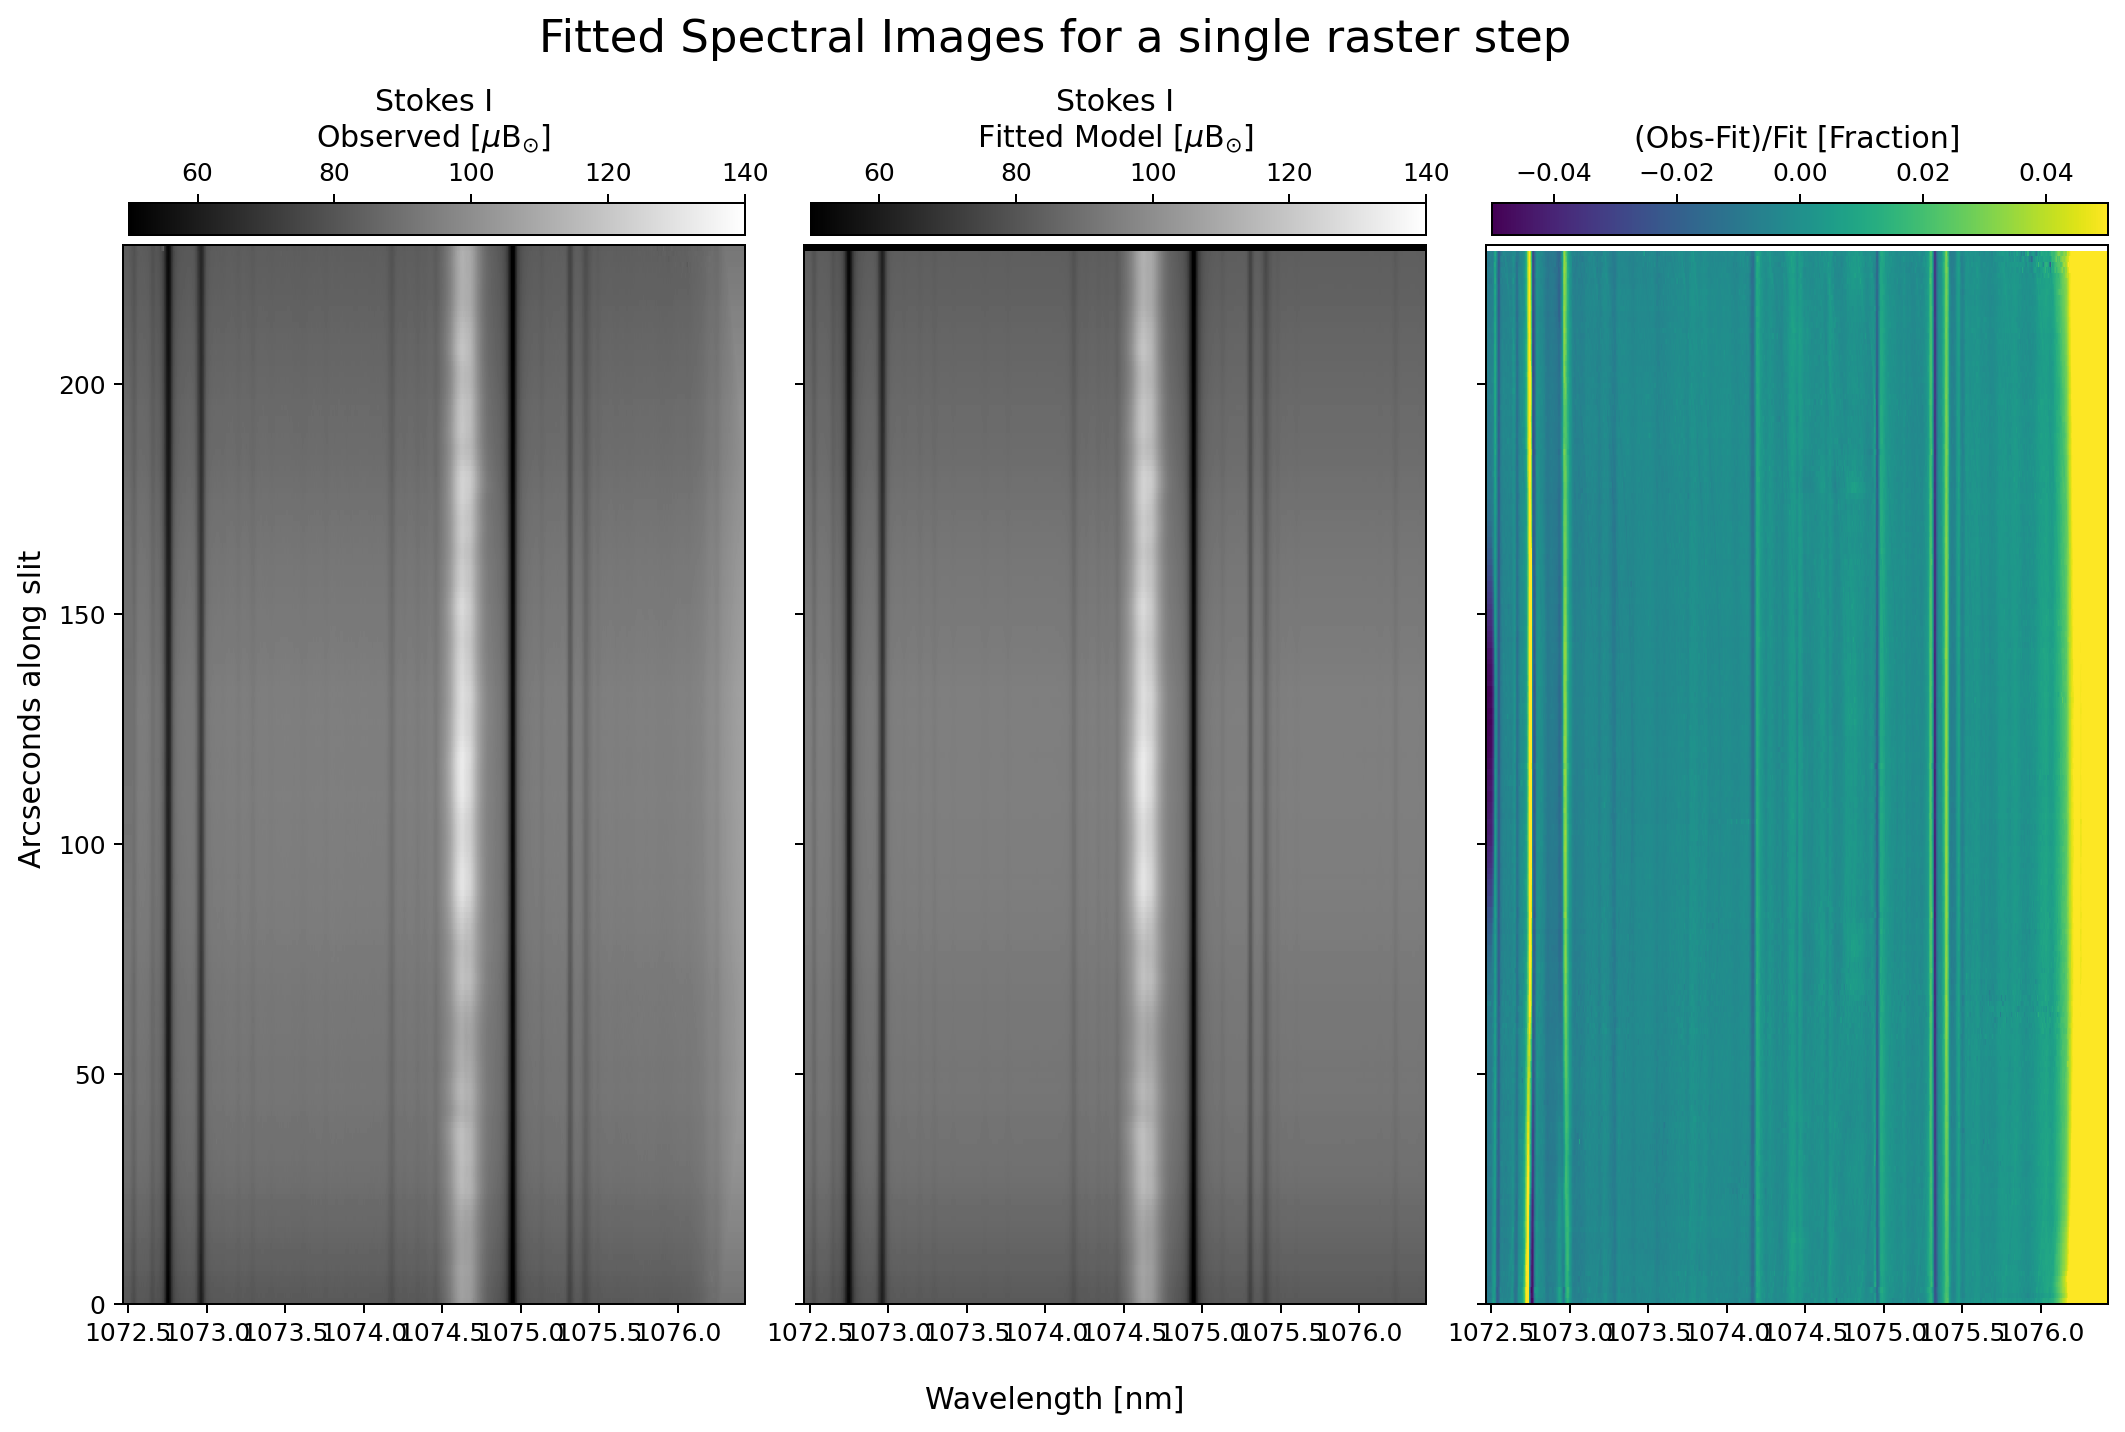

In [47]:
fig,ax = plt.subplots(1,3,figsize = (12,8),sharex=True,sharey=True)
ax = ax.flatten()
im0 = ax[0].imshow(ii_obs,extent = (specCoords[0],specCoords[-1],0,n_alongSlit*slitSamp),aspect = 'auto')
im0.set_clim(50,140)
im1 = ax[1].imshow(ii_fit,extent = (specCoords[0],specCoords[-1],0,n_alongSlit*slitSamp),aspect = 'auto')
im1.set_clim(50,140)
im2 = ax[2].imshow((ii_obs-ii_fit)/ii_fit,extent = (specCoords[0],specCoords[-1],0,n_alongSlit*slitSamp),aspect = 'auto',cmap = 'viridis')
im2.set_clim(-0.05,0.05)

labels = "Stokes I\nObserved","Stokes I\nFitted Model","(Obs-Fit)/Fit"
clabels = "$\mu$B$_{\odot}$","$\mu$B$_{\odot}$",'Fraction'
for n in range(3): ax[n].set_title(labels[n] + ' [' + clabels[n] + ']')

for axi in ax: 
    cax = axi.inset_axes([0.01, 1.01, 0.99, 0.03], transform=axi.transAxes)
    cbar = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax,location = 'top')
    
fig.supxlabel("Wavelength [nm]")
fig.supylabel("Arcseconds along slit")
fig.suptitle("Fitted Spectral Images for a single raster step",fontsize = 18)
fig.tight_layout()
fig.savefig(f"./figures/example_StokesI_spectral_image_fits_with_subtraction.png",dpi = 300)

### Create figure showing all Spectroscopic fit variables

* Here we create maps of all fitted parameters.  Systematic and/or noise-dependent behavior should be examined here.
* The appearance of coronal line features in some of the non-coronal-line parameters may indicated a better model is necessary. 

In [48]:
if stepWidth != 0: 
    imgExtent = (0,n_alongSlit*slitSamp,0,n_scanSteps*stepWidth)
else: 
    imgExtent = (0,n_alongSlit*slitSamp,0,n_scanSteps)

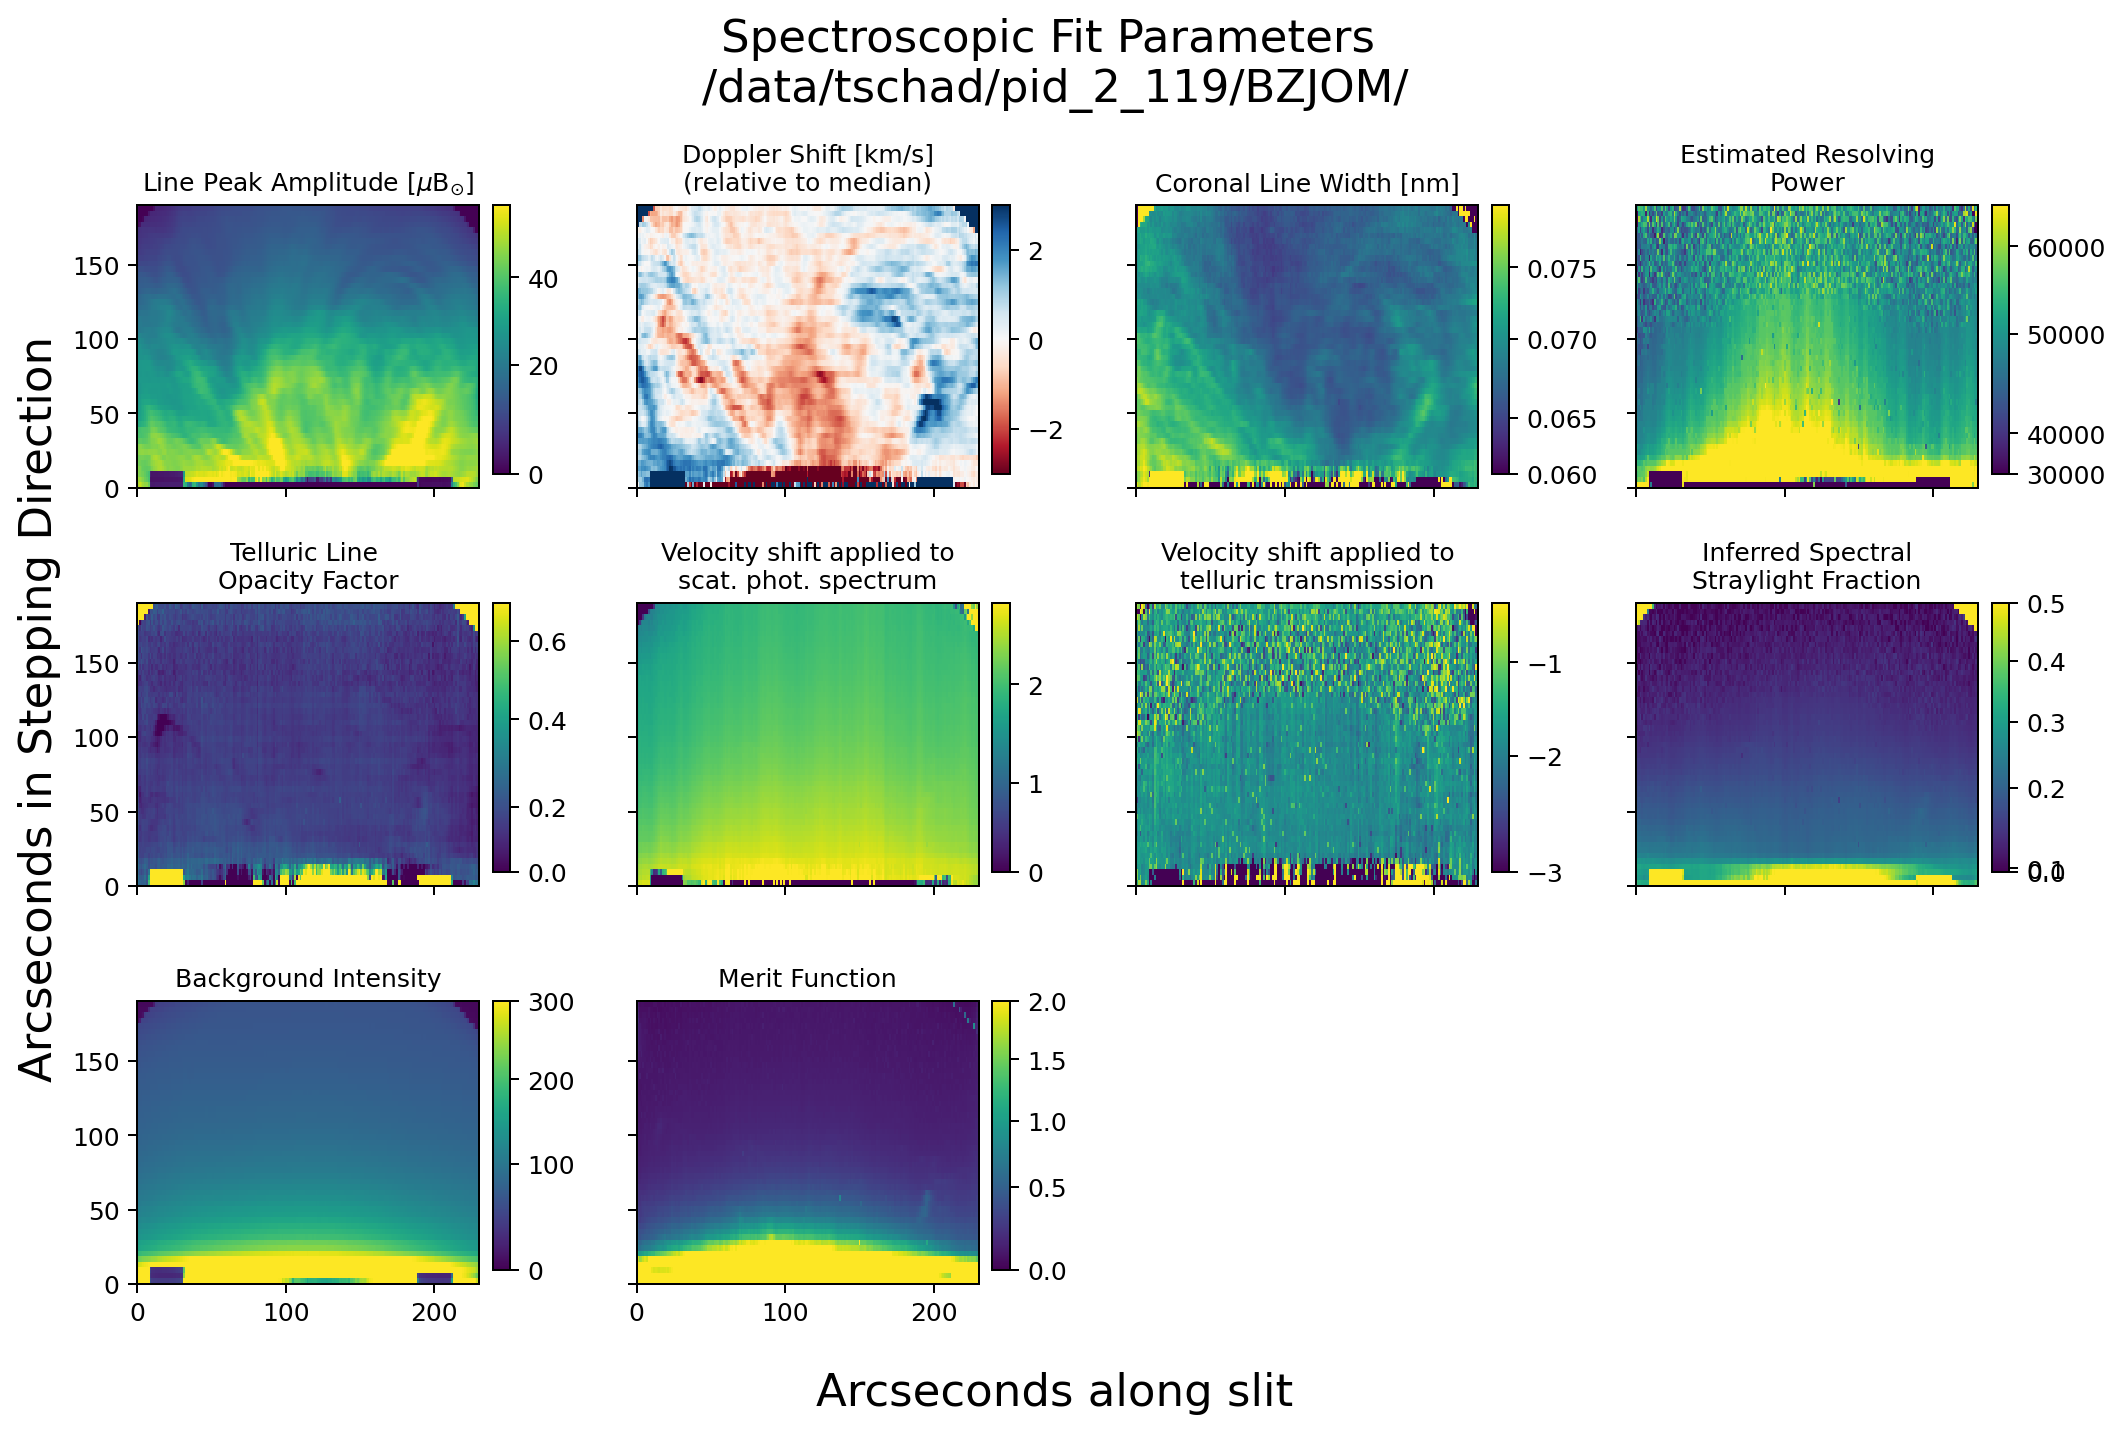

In [49]:
plotTitles= [r"Line Peak Amplitude [$\mu$B$_{\odot}$]", 
             "Doppler Shift [km/s]\n(relative to median)",'Coronal Line Width [nm]',
             'Estimated Resolving\nPower','Telluric Line \nOpacity Factor',
             'Velocity shift applied to\nscat. phot. spectrum',
             'Velocity shift applied to\ntelluric transmission','Inferred Spectral\nStraylight Fraction',
             'Background Intensity','Merit Function']

default_cmap = plt.get_cmap('viridis')
default_cmap.set_bad('indigo')

doppvel_cmap = plt.get_cmap('RdBu')
doppvel_cmap.set_bad('white')

fig,ax = plt.subplots(3,4,figsize = (12,8),sharex=True,sharey=True)
ax = ax.flatten()
for n in range(10): 
    paraMap = fit_results[:,:,n]
    if n !=1: 
        imn = ax[n].imshow(paraMap[:,5::pixel_stride],extent = imgExtent,cmap = default_cmap,norm = PowerNorm(0.85))
        imn.set_clim(np.nanpercentile(fit_results[:,5::pixel_stride,n],[2,98]))
    if n ==1: 
        median_wvc = np.nanmedian(paraMap[:,5::pixel_stride])
        paraMap = (paraMap - median_wvc)/median_wvc*3e5
        imn = ax[n].imshow(paraMap[:,5::pixel_stride],extent = imgExtent,cmap = doppvel_cmap)
        imn.set_clim(-3,3)
    if n==8: imn.set_clim(0,300)
    if n==9: imn.set_clim(0,2)
    ax[n].set_title(plotTitles[n],fontsize = 10)
cbars = []
for axi in ax[0:10]:
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    cbars.append(cbar1)
for axi in ax[10:]: axi.set_visible(False)
    
fig.suptitle("Spectroscopic Fit Parameters \n" + dataset_directory,fontsize = 18 )
fig.supylabel("Arcseconds in Stepping Direction",fontsize = 18)
fig.supxlabel("Arcseconds along slit",fontsize = 18)
fig.tight_layout()  
fig.savefig(f"./figures/dataset_{hdr_dict['DSETID'][0]}_spectroscopic_line_fit_maps.png",dpi = 300)

# Spectropolarimetric line fitting (plus corrections)

* Now we proceed to the spectropolarimetric line fits, which are somewhat more complex.  This is due in part to the presence of residual crosstalk and polarized scattered light profiles from the on-disk structures. 

## Examine Interference Fringing  (Power spectra)

* Quickly, we first look a power spectrum of the polarized Q,U,V profiles.  In data prior to Feb 2024, strong interference fringes are present, and a power spectrum will show prominent peaks.  In the data used in this tutorial, any peaks in the power spectrum are fairly benign and will not be treated or filtered further here.  In the future, tutorials for handling the interference fringes may be made available. 

/tmp/ipykernel_1660469/2725308553.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.plot( 1/f_fringe,estimatePeak2Peak_fringe * 100.,'.-',markersize = 0.2,label = labels[n])


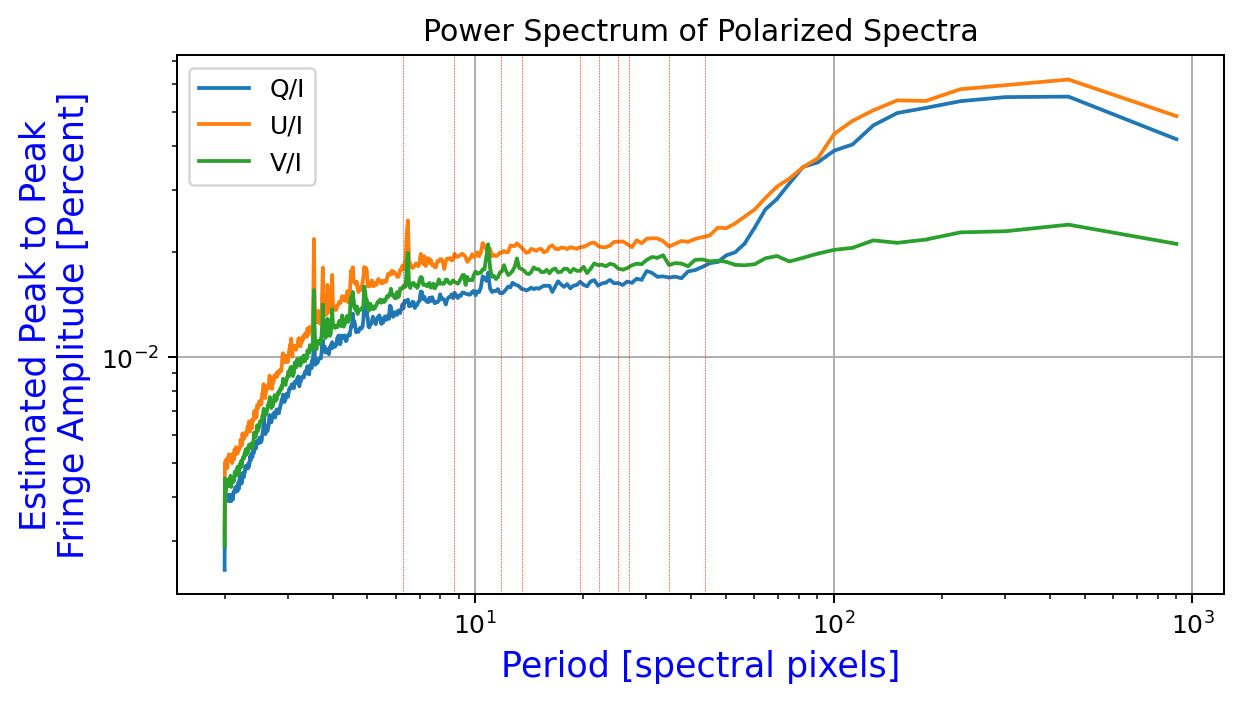

In [50]:
## Get power spectrum 
plt.figure(figsize = (7,4))
labels = 'I','Q/I','U/I','V/I'
stokesSpec = np.copy(data[:,n_scanSteps//2,0,:,:])
for n in range(1,4): 
    x_over_i = stokesSpec[n]  / stokesSpec[0] 
    x_over_i = x_over_i - np.nanmedian(x_over_i,axis=0)[None,:]
    f_fringe, pxx_fringe = signal.periodogram(x_over_i,fs = 1,window = 'hann',scaling = 'spectrum')
    ## will take the 95th percentile value of the individual row power spectrum to get an estimate of the largest magnitude 
    pxx_fringe = np.nanpercentile(pxx_fringe,75,axis=0)
    estimateAmplitude_fringe = np.sqrt(pxx_fringe) * np.sqrt(2)  ## peak amplitude
    estimatePeak2Peak_fringe = np.sqrt(pxx_fringe) * np.sqrt(2) * 2. 
    plt.plot( 1/f_fringe,estimatePeak2Peak_fringe * 100.,'.-',markersize = 0.2,label = labels[n])
plt.legend()
plt.xlabel("Period [spectral pixels]" ,fontsize = 14,color = 'blue')
plt.xscale('log')
plt.ylabel("Estimated Peak to Peak\nFringe Amplitude [Percent]",fontsize = 14,color = 'blue')
plt.yscale('log')
plt.grid()

freqs2rm = 1./np.array([6.3,8.75,11.8,13.47,19.6,22.2,26.9,25,34.8,43.8])    ## location of prominent peaks in pre Feb 2024 1074 nm data
for ff in freqs2rm: 
    plt.axvline(1/ff,ls = 'dashed',color = 'red',lw = 0.2)

plt.title("Power Spectrum of Polarized Spectra")
plt.tight_layout()
fig.savefig(f"./figures/dataset_{hdr_dict['DSETID'][0]}_polarized_spectral_power_spectrum.png",dpi = 300)

## Create a fitting function for the full Stokes spectrum

* The forward model in this case is considerable more complex; however the key principles are the same.
* Additional features that must be taken into consideration are:
    * Intensity to Q,U,V crosstalk
    * Q,U to V crosstalk
    * Polarized profiles of the parasistic photospheric scattered light
* The model below utilizes some portion of the approach of Schad et al. (2022); however, it is assumed that "most" of the polarimetric crosstalk is already removed and that only small corrections are necessary.
* For the I->Q,U,V crosstalk, we seek to optimize a model such that the solar photospheric lines have zero polarization in Q and U, and can be fit with an anti-symmetric Stokes V profile according to the weak field approximation.
* For (Q,U) to V crosstalk, the contraint is that the coronal stokes V signal is expected to be antisymmetric in the weak field approximation.  (This may not be always physically true, but this approach is required at this stage).
* V to Q,U is assumed to be neglible.
* We do not zero out continuum polarization, but instead seek to recover the amplitude and direction of the linear polarized Thomson scattered K-corona. 

In [51]:
## Define spectral weights to apply

## STOKES I 
Iwgts = np.ones_like(specCoords)
Iwgts[0:75] = 0  ## ....set edge weights to zero to mitigate flat field artifacts
Iwgts[(-75):] = 0 ## ....set edge weights to zero to mitigate flat field artifacts
Iwgts[(specCoords>(wvc-0.5))*(specCoords<(wvc+0.5))] = 5.  ## ...increase weights in vicintiy of the coronal line to bias the fit to this region 
Iwgts = Iwgts/np.max(Iwgts) ## ...normalize weights 

## Stokes Q and U weights (100 x that of I)
Qwgts = Iwgts * 1
Uwgts = Iwgts * 1

## Stokes V
Vwgts = Iwgts*0. 
Vwgts[(specCoords>(wvc-0.5))*(specCoords<(wvc+0.5))] = 1.  ## ...increase weights only in vicintiy of the coronal line to bias the fit to this region 

wv_mean = specCoords.mean()
dwv = np.abs(specCoords[0]-specCoords[1])

@njit(fastmath=True)
def modelStokes(para,ii,qq,uu,vv,returnModel=False): 
    ''' Forward model of spectral line observation assuming single Gaussian profile for coronal line 
    
        Parameters within para input list are: 

        lineAmp    -- Gaussian function amplitude of the coronal line in micro-B
        lineCenWv  -- Coronal line center wavelength (including Doppler shift) in nm 
        lineWidth  -- Gaussian line width in nm  
        LSF_RPOW   -- Resolving power of line spread function 
        opac       -- An opacity factor to modify total telluric line absorpance 
        velS       -- Velocity shift of solar atlas relative to observed spectrum
        velT       -- Velocity shift of telluic atlas relative to observed spectrum
        strayfrac  -- Additional scalar fraction of straylight within spectrograph (i.e. the "veil" component)
        icont      -- Amplitude of the background continuum intensity (dominated by scattered light)
    
    '''
    ## FIT VARIABLES..........................
    lineAmp,lineCenWv,lineWidth,LSF_RPOW,opac,velS,velT,strayfrac,icont = para[:9]  ## intensity variables
    linpol_frac,linpol_ang,BLOS_GAUSS,contPol_Q,contPol_U = para[9:14]   ## polarized amplitudes
    i2q,i2u,i2v,q2v,u2v = para[14:19]  ## crosstalk terms 
    strayVamp= para[19:] ## amplitude scaling of the photosphere V signal under the weak field approximation 

    ## correct the input data for the crosstalk term 
    vv = vv - q2v*qq
    vv = vv - u2v*uu
    qq = qq - i2q*ii 
    uu = uu - i2u*ii 
    vv = vv - i2v*ii 

    ## coronal line Gaussian model 
    coronal_line = lineAmp*np.exp(-(specCoords-lineCenWv)**2/(2*lineWidth**2)) 
    
    ## scattered light and telluric transmission models 
    ftsTmod = np.interp(specCoords,specCoords + velT/3e5*wv_mean,trans_telluric**opac)
    ftsSmod = np.interp(specCoords,specCoords + velS/3e5*wv_mean,atlas_solar)
    ftsmod  = ftsTmod * ftsSmod 

    ## add straylight and scale for amplitude
    ftsmod = icont * (ftsmod + strayfrac) / (1. + strayfrac)
    
    ## combine components
    ifit = ftsmod + (coronal_line * ftsTmod)     
    
    ## q and u fit 
    lfit = linpol_frac*coronal_line
    qfit =  np.cos(2.*linpol_ang)*lfit  + contPol_Q 
    ufit = -np.sin(2.*linpol_ang)*lfit  + contPol_U

    ## Coronal WFA longitudinal magnetic field (Lande geff = 1.5)
    wfa_factor = -4.6686e-10 * (wvc*10.)**2 * 1.5 /1000./10.  ### in nm 
    vfit = wfa_factor * gradient_1d(coronal_line,specCoords[1]-specCoords[0]) * BLOS_GAUSS
    
    ## include telluric absorption in polarized states as well
    qfit *= ftsTmod 
    ufit *= ftsTmod 
    vfit *= ftsTmod

    ## Gaussian convolution of the FTS atlas
    kern_pix  = (wvc / LSF_RPOW) / 2.3548200450309493 / dwv
    ifit = gaussian_filter1d_numba(ifit, kern_pix) 
    qfit = gaussian_filter1d_numba(qfit, kern_pix) 
    ufit = gaussian_filter1d_numba(ufit, kern_pix) 
    vfit = gaussian_filter1d_numba(vfit, kern_pix) 

    ## Additional polarized photospheric circular polarization profile
    vstray = ftsTmod * strayVamp * gradient_1d(ftsSmod,specCoords[1]-specCoords[0])
    vstray = gaussian_filter1d_numba(vstray, kern_pix) 

    ## returns fitted i,q,u,v without crosstalk and photospherie v straylight 
    ## also correct qq,uu,vv and the vstraylight profile that is not removed from vv yet. 
    return  ifit,qfit,ufit,vfit,qq,uu,vv,vstray

@njit(fastmath=True)
def objFuncFullStokes(para,ii,qq,uu,vv):
    ''' Objective function -- Reduced Chi-Squared Statistic ''' 

    ifit,qfit,ufit,vfit,qqc,uuc,vvc,vstray = modelStokes(para,ii,qq,uu,vv)

    ## reduced Chi-Squared statistic 
    ires = np.sum((ii-ifit)**2 * Iwgts)   /np.sum(Iwgts)
    qres = np.sum((qqc-qfit)**2 * Qwgts)  /np.sum(Qwgts)
    ures = np.sum((uuc-ufit)**2 * Uwgts)  /np.sum(Uwgts)
    vres = np.sum(((vvc-vstray)-vfit)**2  * Vwgts) /np.sum(Vwgts)

    return  (ires+5*qres+5*ures+50*vres)/(61.)

## Example full Stokes fit

In [52]:
%%time 
step = 12
yp = 885
ii = np.nanmean(data[0,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))
qq = np.nanmean(data[1,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))
uu = np.nanmean(data[2,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))
vv = np.nanmean(data[3,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))

CPU times: user 945 µs, sys: 835 µs, total: 1.78 ms
Wall time: 1.51 ms


In [ ]:
%%time 
## Bounds of the model variables
pnames ='lineAmp','lineCenWv','lineWid','LSF_FWHM','opacity','velS','velT','strayfrac','icont','linpol_frac','linpol_ang','BLOS_GAUSS','contPol_Q','contPol_U','i2q','i2u','i2v','q2v','u2v','strayVamp'
boundsFullStokes = [(0,2*(np.max(ii)-np.nanmedian(ii))),                            ## line ampltitude in millionths 
          (wvc*(1-10/3e5),wvc*(1.+10/3e5)),  ## coronal line center wavelength [nm]
          (0.055,0.1),                       ## coronal Gaussian line width [nm]
          (37000,65000),                  ## Resolving power of line spread function 
          (0.05,0.7),                          ## telluric opacity factor 
          (0,3),                             ## velocity shift in km/s for the solar atlas  [TUNED ACCORDING TO PRELIMINARY FITS]
          (-3,0),                            ## velocity shift in km/s for the telluric atlas [TUNED ACCORDING TO PRELIMINARY FITS]
          (0.,0.5),                          ## Spectrograph constant straylight fraction 
          (np.nanmedian(ii)-3,np.nanmedian(ii)+3),  ## Amplitude of the background scattered light in millionths    
          (0.,0.1),(-np.pi/2,np.pi/2),(-50,50),  ## linpol_frac,linpol_ang,BLOS_GAUSS
          (-1.5,1.5),(-1.5,1.5),  ## continuum polarization Q , same for U (millionths)
          (-0.02,0.02),(-0.02,0.02),(-0.02,0.02), ## i->q,u,v crosstalk terms
          (-0.2,0.2),(-0.2,0.2),(-0.02,0.02)]  ## q2v,u2v, strayVamp 

res2 = differential_evolution(objFuncFullStokes,boundsFullStokes,args = (ii,qq,uu,vv,),disp = True,tol=1.e-14,maxiter = 1400,popsize = 1,polish = True) 

In [54]:
print(f"Objective function final value: {res2.fun}")
print("Parameter values...")
for n in range(len(res2.x)): 
    print(f"{str(n).ljust(6)}  {pnames[n].rjust(10)}:  {res2.x[n]:10.4f}    Bounds (Min): {boundsFullStokes[n][0]:9.3f}   (Max): {boundsFullStokes[n][1]:9.3f}")
## Calculate fitted profile
ifit,qfit,ufit,vfit,qqc,uuc,vvc,vstray = modelStokes(res2.x,ii,qq,uu,vv,returnModel=True)

Objective function final value: 0.010643266504683278
Parameter values...
0          lineAmp:     44.2697    Bounds (Min):     0.000   (Max):    86.446
1        lineCenWv:   1074.6360    Bounds (Min):  1074.614   (Max):  1074.686
2          lineWid:      0.0679    Bounds (Min):     0.055   (Max):     0.100
3         LSF_FWHM:  62040.8843    Bounds (Min): 37000.000   (Max): 65000.000
4          opacity:      0.1814    Bounds (Min):     0.050   (Max):     0.700
5             velS:      2.4629    Bounds (Min):     0.000   (Max):     3.000
6             velT:     -1.7883    Bounds (Min):    -3.000   (Max):     0.000
7        strayfrac:      0.1923    Bounds (Min):     0.000   (Max):     0.500
8            icont:    148.8601    Bounds (Min):   145.269   (Max):   151.269
9       linpol_frac:      0.0173    Bounds (Min):     0.000   (Max):     0.100
10      linpol_ang:     -0.1690    Bounds (Min):    -1.571   (Max):     1.571
11      BLOS_GAUSS:      3.9488    Bounds (Min):   -50.000   (Max): 

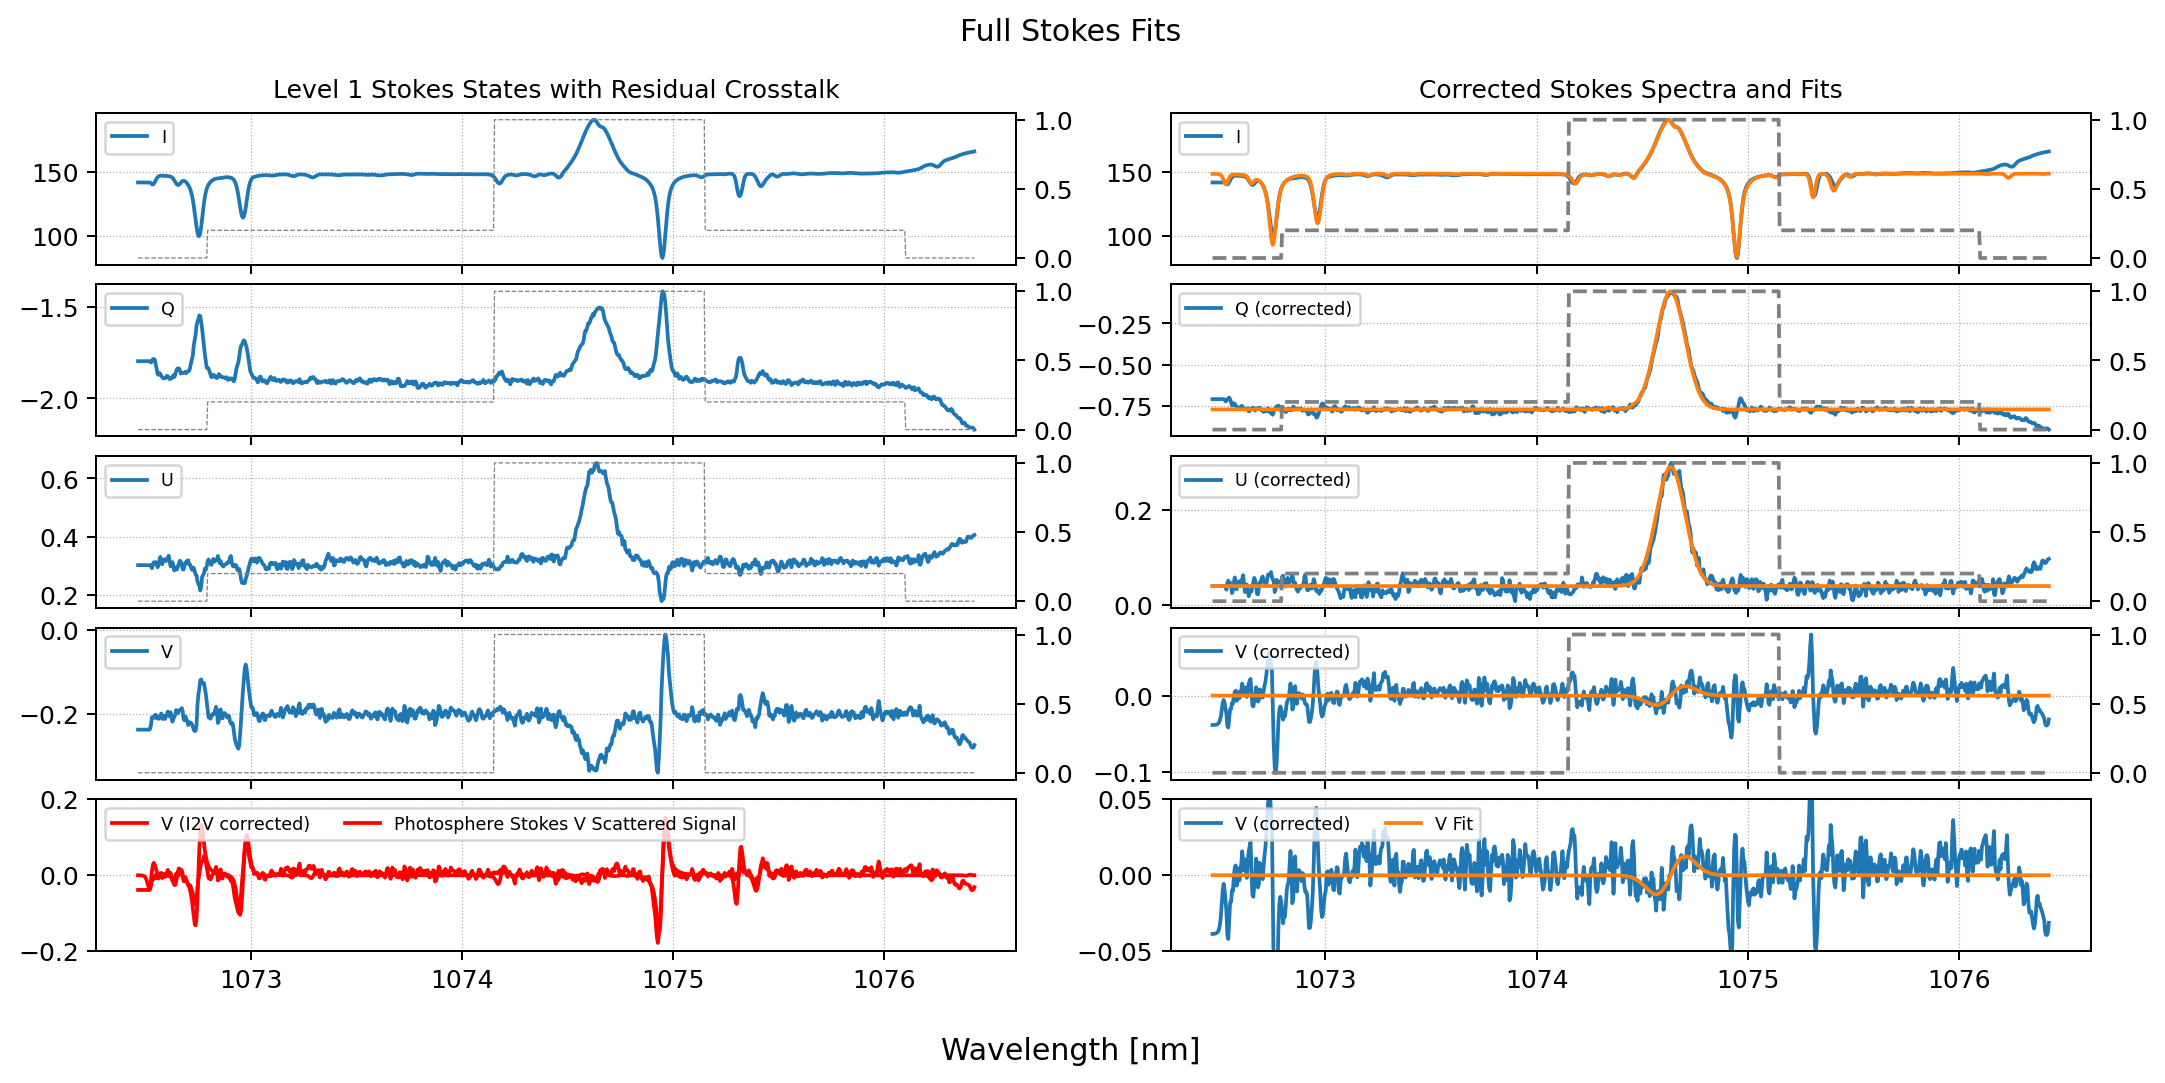

In [55]:
fig,ax= plt.subplots(5,2,figsize = (12,6),sharex=True)

dd = ii,qq,uu,vv 
dd_labels = 'I','Q','U','V'
ddc = ii,qqc,uuc,vvc - vstray
ddc_labels = 'I','Q (corrected)','U (corrected)','V (corrected)'
ff = ifit,qfit,ufit,vfit
wgts = Iwgts,Qwgts,Uwgts,Vwgts

for n in range(4): 
    ax[n][0].plot(specCoords,dd[n],label = dd_labels[n])
    ax[n][0].twinx().plot(specCoords,wgts[n],lw = 0.5,ls = 'dashed',color = 'grey')
    ax[n][1].plot(specCoords,ddc[n],label = ddc_labels[n])
    ax[n][1].plot(specCoords,ff[n])
    ax[n][1].twinx().plot(specCoords,wgts[n],ls = 'dashed',color = 'grey')

ax[4][0].plot(specCoords,vvc ,'r',label = 'V (I2V corrected)')
ax[4][0].plot(specCoords,vstray ,'r',label = 'Photosphere Stokes V Scattered Signal')
ax[4][0].set_ylim(-0.2,0.2)

ax[4][1].plot(specCoords,vvc - vstray,label = 'V (corrected)')
ax[4][1].plot(specCoords,vfit ,label = 'V Fit')
ax[4][1].set_ylim(-0.05,0.05)

ax[0][0].set_title("Level 1 Stokes States with Residual Crosstalk",fontsize = 10)
ax[0][1].set_title("Corrected Stokes Spectra and Fits",fontsize = 10)
fig.suptitle("Full Stokes Fits")

for axi in ax.flatten(): 
    axi.grid(lw = 0.5,ls = 'dotted')
    axi.legend(fontsize = 7,loc = 'upper left',ncols =2)
    axi.set_xticks([1073,1074,1075,1076])
fig.supxlabel("Wavelength [nm]")
fig.tight_layout(h_pad = 0.05)
fig.savefig(f"./figures/example_FullStokes_line_fits.png",dpi = 300)

## Fits across the raster map 

In [56]:
def work(argin): 
    step,yp = argin 

    ii = np.nanmean(data[0,step:(step+2),0,(yp-20):(yp+20),:],axis=(0,1))
    qq = np.nanmean(data[1,step:(step+2),0,(yp-20):(yp+20),:],axis=(0,1))
    uu = np.nanmean(data[2,step:(step+2),0,(yp-20):(yp+20),:],axis=(0,1))
    vv = np.nanmean(data[3,step:(step+2),0,(yp-20):(yp+20),:],axis=(0,1))
    
    boundsFullStokes = [(0,2*(np.max(ii)-np.nanmedian(ii))),                            ## line ampltitude in millionths 
          (wvc*(1-10/3e5),wvc*(1.+10/3e5)),  ## coronal line center wavelength [nm]
          (0.055,0.1),                       ## coronal Gaussian line width [nm]
          (37000,65000),                  ## Resolving power of line spread function 
          (0.05,0.7),                          ## telluric opacity factor 
          (0,3),                             ## velocity shift in km/s for the solar atlas  [TUNED ACCORDING TO PRELIMINARY FITS]
          (-3,0),                            ## velocity shift in km/s for the telluric atlas [TUNED ACCORDING TO PRELIMINARY FITS]
          (0.,0.5),                          ## Spectrograph constant straylight fraction 
          (np.nanmedian(ii)-3,np.nanmedian(ii)+3),  ## Amplitude of the background scattered light in millionths    
          (0.,0.1),(-np.pi/2,np.pi/2),(-50,50),  ## linpol_frac,linpol_ang,BLOS_GAUSS
          (-1.5,1.5),(-1.5,1.5),  ## continuum polarization Q , same for U (millionths)
          (-0.02,0.02),(-0.02,0.02),(-0.02,0.02), ## i->q,u,v crosstalk terms
          (-0.2,0.2),(-0.2,0.2),(-0.02,0.02)]  ## q2v,u2v, strayVamp 
        
    try: 
        res = differential_evolution(objFuncFullStokes,boundsFullStokes,args = (ii,qq,uu,vv,),disp = False,tol=1.e-14,maxiter = 400,popsize = 1,polish = True)         
        return step,yp,res.x,res.fun
    except:
        return step,yp,np.zeros(len(boundsFullStokes)),np.nan
    return 

In [57]:
%%time   
## View time for one fit 
step = n_scanSteps//2
yp   = n_alongSlit//2
step_out,yp_out,result_out,objfun_out = work((step,yp))
print(objfun_out)

0.0030499358561274187
CPU times: user 2.05 s, sys: 0 ns, total: 2.05 s
Wall time: 2.05 s


In [58]:
## INITIAL FITTING EVERY 10 PIXELS ALONG THE SLIT 
pixel_stride = 10

if 0:   ## set to 1 to actually run all fits (takes a bit of time) 
    ncpus = min(multiprocessing.cpu_count() , 70)
    p     = multiprocessing.Pool(processes=ncpus,maxtasksperchild = 1000)
    arg_array = []
    for step in range(0,data.shape[1]): 
        for yp in range(5,data.shape[3]-5,pixel_stride): 
            arg_array.append((step,yp))

    rs    = p.imap(work,arg_array)
    p.close()
    
    pbar = tqdm(total=len(arg_array),position = 0, leave = True)

    fit_results = np.zeros((data.shape[1],data.shape[3],len(boundsFullStokes)+1),dtype = float)
    
    for i,res in enumerate(rs):
        step,yp,result_out,objfun_out = res 
        fit_results[step,yp,:(-1)] = result_out 
        fit_results[step,yp,-1] = objfun_out  
        pbar.update()
    pbar.close()

    np.save(output_directory + 'FullStokes_line_fit_results.npy',fit_results)

else:
    fit_results = np.load(output_directory + 'FullStokes_line_fit_results.npy')

### Create figure showing Stokes spectral fits at one step

In [59]:
## plot up some example spectra
step = 11
StokesSpec_Corr = np.zeros((4,n_alongSlit,n_wv))
for yp in trange(5,data.shape[3]-5,pixel_stride): 
    try: 
        ii = np.nanmean(data[0,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))
        qq = np.nanmean(data[1,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))
        uu = np.nanmean(data[2,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))
        vv = np.nanmean(data[3,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))
        ifit,qfit,ufit,vfit,qqc,uuc,vvc,vstray = modelStokes(fit_results[step,yp,:(-1)],ii,qq,uu,vv,returnModel=True)
        StokesSpec_Corr[:,yp,:] = ii,qqc,uuc,vvc
    except:
        continue

  0%|          | 0/191 [00:00<?, ?it/s]

/tmp/ipykernel_1660469/209709326.py:6: RuntimeWarning: Mean of empty slice
  ii = np.nanmean(data[0,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))
/tmp/ipykernel_1660469/209709326.py:7: RuntimeWarning: Mean of empty slice
  qq = np.nanmean(data[1,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))
/tmp/ipykernel_1660469/209709326.py:8: RuntimeWarning: Mean of empty slice
  uu = np.nanmean(data[2,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))
/tmp/ipykernel_1660469/209709326.py:9: RuntimeWarning: Mean of empty slice
  vv = np.nanmean(data[3,step:(step+2),0,(yp-30):(yp+30),:],axis=(0,1))


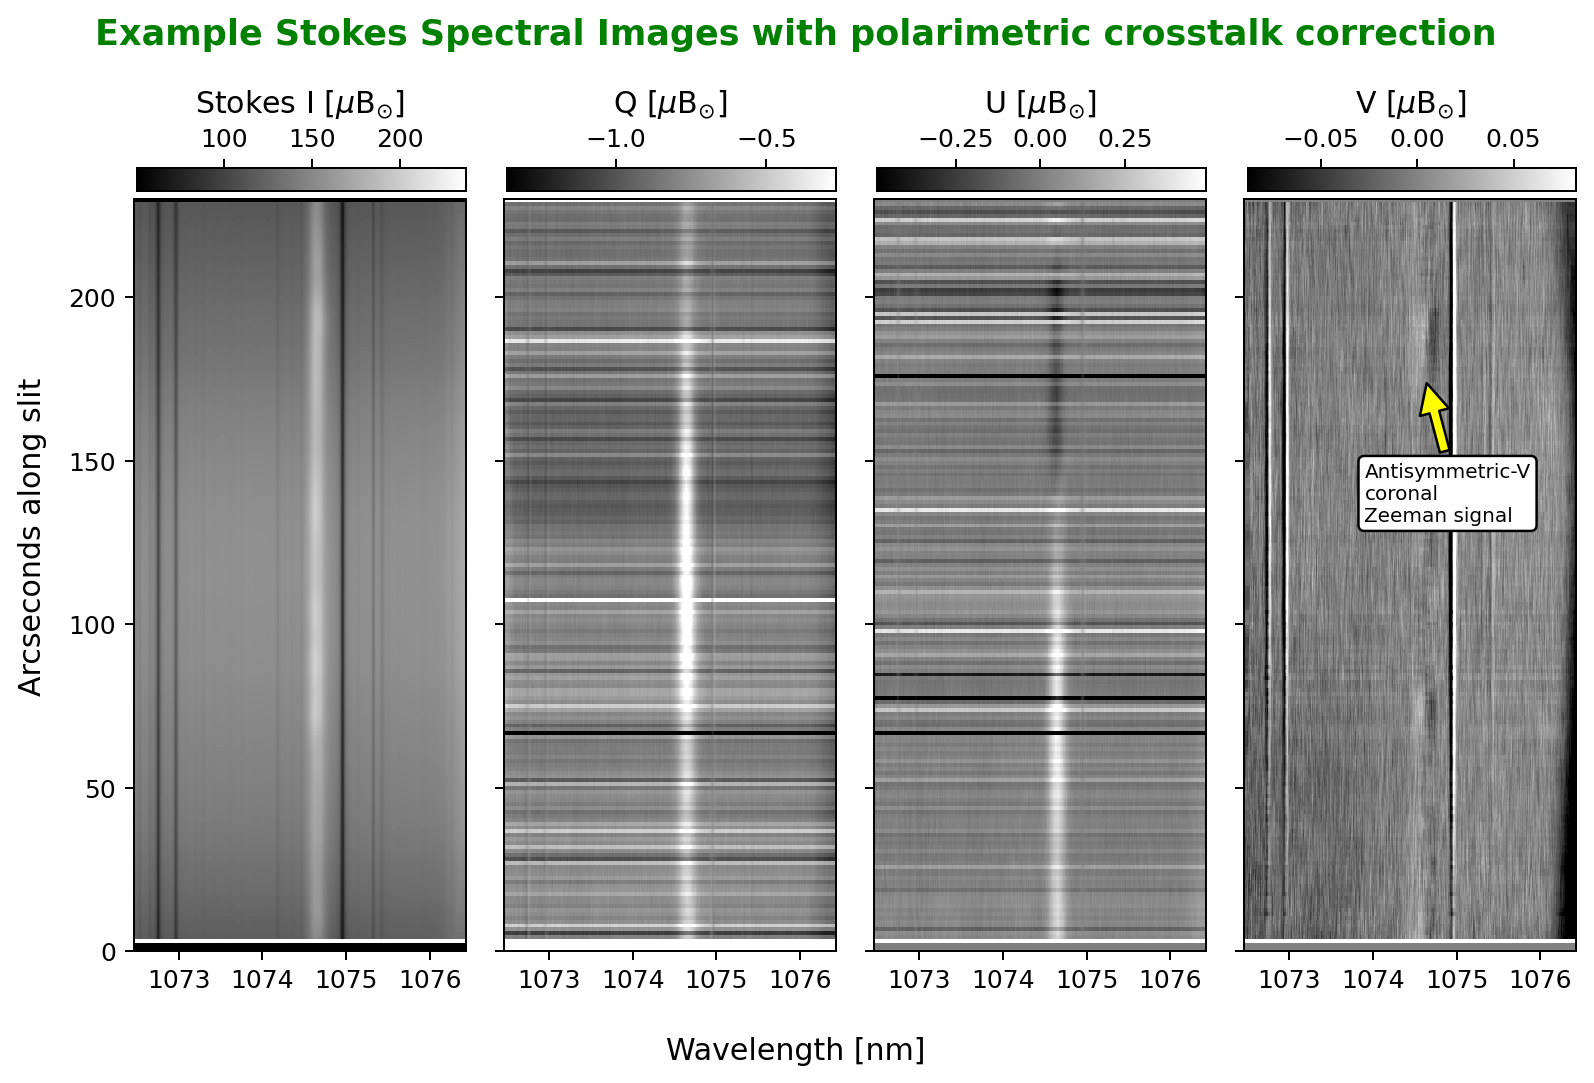

In [60]:
fig,ax = plt.subplots(1,4,figsize = (9,6),sharex=True,sharey=True)
ax = ax.flatten()

labels = 'Stokes I','Q','U','V'
for n in range(4):
    img2show = StokesSpec_Corr[n,5::pixel_stride]
    imn = ax[n].imshow(img2show,extent = (specCoords[0],specCoords[-1],0,n_alongSlit*slitSamp),aspect = 'auto')
    imgMin,imgMed,imgMax = np.nanpercentile(img2show,[1,50,99]) 
    imn.set_clim(imgMed - 0.5*(imgMax-imgMin),imgMed + 0.5*(imgMax-imgMin))
    ax[n].set_title(labels[n] + r' [$\mu$B$_{\odot}$]')

for axi in ax: 
    cax = axi.inset_axes([0.01, 1.01, 0.99, 0.03], transform=axi.transAxes)
    cbar = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax,location = 'top')

fig.supxlabel("Wavelength [nm]")
fig.supylabel("Arcseconds along slit")

bbox = dict(boxstyle="round", fc="white")
ax[3].annotate("Antisymmetric-V\ncoronal\nZeeman signal", (1074.63,175),(1073.9,140.),bbox = bbox,
               fontsize = 8, arrowprops=dict(facecolor='yellow', shrink=0.05,lw = 1),ha='left',va='center')

fig.suptitle("Example Stokes Spectral Images with polarimetric crosstalk correction",color = 'green',fontsize = 14,fontweight = 'bold')
fig.tight_layout()
fig.savefig(f"./figures/example_FullStokes_corrected_spectral_images.png",dpi = 300)

### Create figure showing maps of quantities

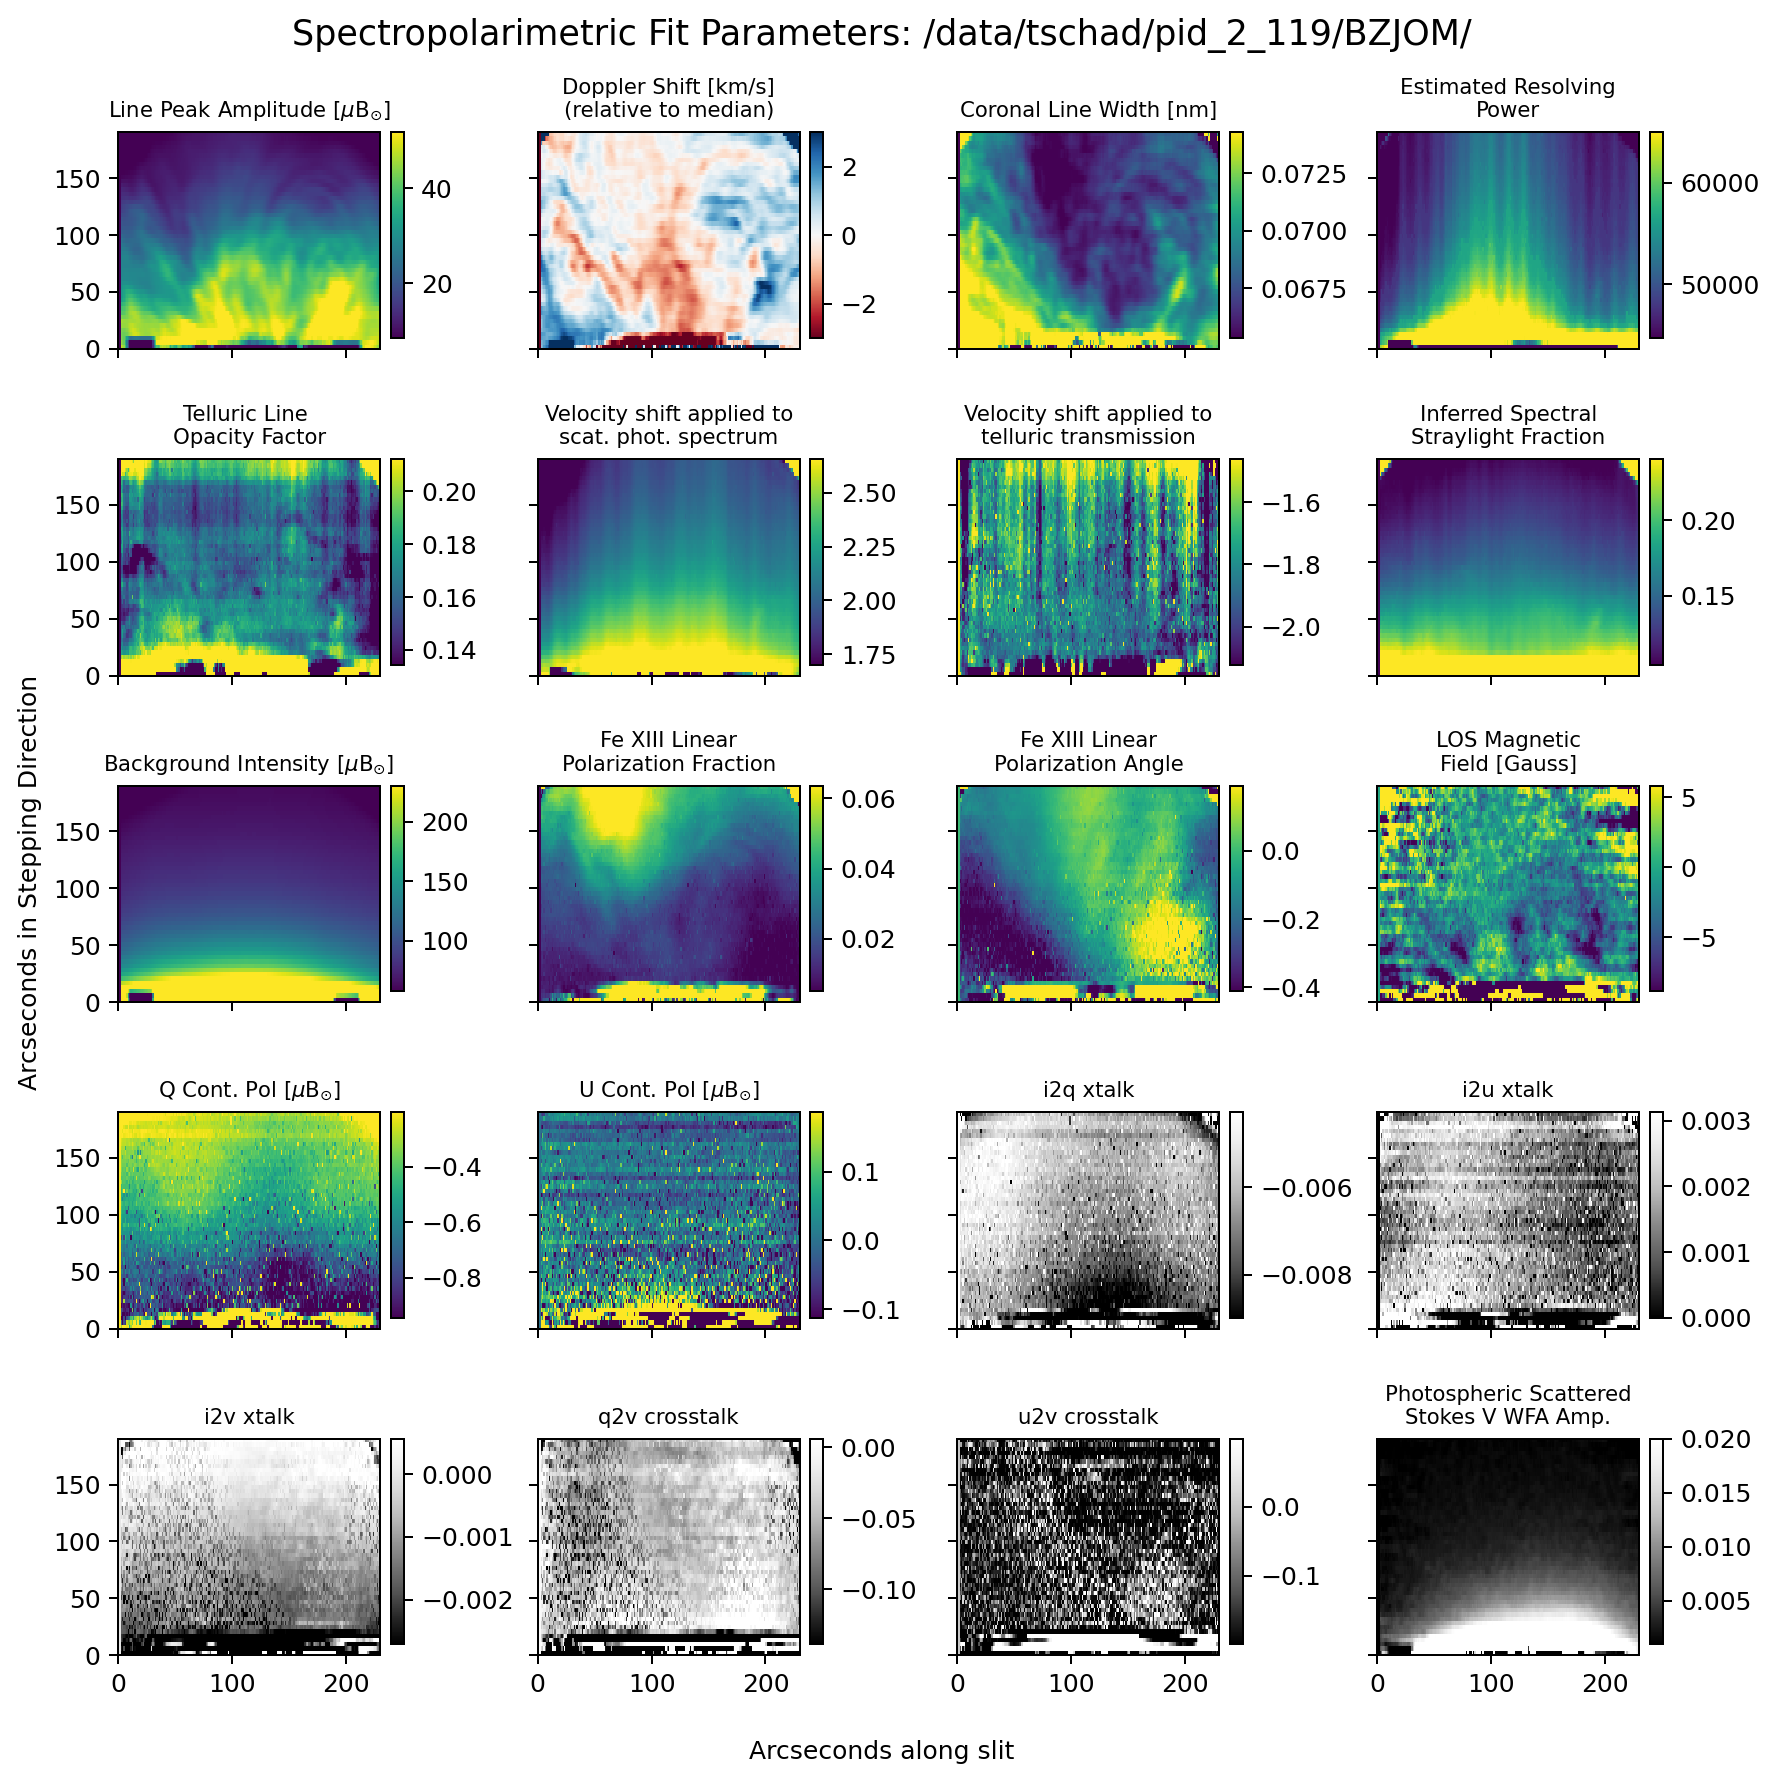

In [61]:
plotTitles= [r"Line Peak Amplitude [$\mu$B$_{\odot}$]", 
             "Doppler Shift [km/s]\n(relative to median)",'Coronal Line Width [nm]',
             'Estimated Resolving\nPower','Telluric Line \nOpacity Factor',
             'Velocity shift applied to\nscat. phot. spectrum',
             'Velocity shift applied to\ntelluric transmission','Inferred Spectral\nStraylight Fraction',
             r'Background Intensity [$\mu$B$_{\odot}$]','Fe XIII Linear\nPolarization Fraction','Fe XIII Linear\nPolarization Angle',
             'LOS Magnetic\nField [Gauss]','Q Cont. Pol [$\mu$B$_{\odot}$]','U Cont. Pol [$\mu$B$_{\odot}$]','i2q xtalk','i2u xtalk','i2v xtalk','q2v crosstalk','u2v crosstalk','Photospheric Scattered\nStokes V WFA Amp.',
             'Merit Function']

default_cmap = plt.get_cmap('viridis')
doppvel_cmap = plt.get_cmap('RdBu')

fig,ax = plt.subplots(5,4,figsize = (10,10),sharex=True,sharey=True)
ax = ax.flatten()
for n in range(20): 
    paraMap = fit_results[:,:,n]
    if n !=1: 
        imn = ax[n].imshow(paraMap[:,5::pixel_stride],extent = imgExtent,cmap = default_cmap)
        imn.set_clim(np.nanpercentile(fit_results[:,5::pixel_stride,n][3:,:],[5,95]))
    if n ==1: 
        median_wvc = np.nanmedian(paraMap[:,5::pixel_stride])
        paraMap = (paraMap - median_wvc)/median_wvc*3e5
        imn = ax[n].imshow(paraMap[:,5::pixel_stride],extent = imgExtent,cmap = doppvel_cmap)
        imn.set_clim(-3,3)
    if n >13: imn.set_cmap('Greys_r')
    ax[n].set_title(plotTitles[n],fontsize = 8.5)
cbars = []
for axi in ax:
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    cbars.append(cbar1)

fig.suptitle("Spectropolarimetric Fit Parameters: " + dataset_directory,fontsize = 14 )
fig.supylabel("Arcseconds in Stepping Direction",fontsize = 10)
fig.supxlabel("Arcseconds along slit",fontsize = 10)
fig.tight_layout()  
fig.savefig(f"./figures/dataset_{hdr_dict['DSETID'][0]}_polarimetric_line_fit_maps.png",dpi = 300)